In [2]:
import numpy as np
import pandas as pd
import functions.multi_occupation_network as multi_occupation_network
import functions.nominal_rigidity_network as nominal_rigidity_network
import matplotlib.pyplot as plt
from  functions.network_figures import bar_plot

# Calibration Excersize 3: Multiple Major Occupations

We now allow for a more flexible occupation-sector structure, using occupation-by-sector employment data from the Occupational Employment and Wage Statistics (OEWS). In particular, we are able to calibrate $\varepsilon^f_N$ and $\mathcal{L}$ from the OES, and we impute the other variables from sector-level data. 

In [3]:
A_spec = 1
data_dir = '../data/clean/'
dfTau    = pd.read_csv(data_dir + 'tau_2021.csv').sort_values(by=['short_names'])
dfepsN   = pd.read_csv(data_dir + 'epsN_2021.csv', index_col=0).sort_index(axis=1)
dfcurlyL = pd.read_csv(data_dir + 'curlyL_2021.csv', index_col=0).sort_index()
dfA      = pd.read_csv(data_dir + f'A{A_spec}.csv')
sectors  = dfA['short_names']
dfDemand = pd.read_csv(data_dir + 'demand_tab.csv')
dfLshare = pd.read_csv(data_dir + 'labor_tab.csv')
dfLabor_market_yearly= pd.read_csv(data_dir + 'uvh_annual_updated.csv')
dfLabor_market_yearly = dfLabor_market_yearly.sort_values(by=['Year', 'short_names'])
dfLabor_market_yearly = dfLabor_market_yearly.dropna(axis=0)
dfLabor_market_yearly = dfLabor_market_yearly[dfLabor_market_yearly['Year'] == 2021]
dfMatching_params = pd.read_csv(data_dir + 'matching_param_estimates.csv')
shares = pd.read_csv(data_dir + 'energy_capital_shares.csv')
sector_names = list(dfA['short_names']) + ['Agg Y']
occupation_names = list(dfcurlyL.index)
dfepsN_weights = dfepsN.rename_axis('short_names').reset_index().melt(id_vars='short_names')

In [5]:
dfepsN_weights.groupby('short_names')['value'].sum()

short_names
accom       1.0
const       1.0
dur         1.0
edhealth    1.0
fin         1.0
gov         1.0
info        1.0
mining      1.0
nondur      1.0
other       1.0
profserv    1.0
trade       1.0
trans       1.0
Name: value, dtype: float64

We compute occupation-level recruiter-producer ratio by computing an average of recruiter-producer ratios for industries that employ this occupation, weighted by their wage expenditure 

In [5]:
dfTau.head()

,Industry,TOT_EMP,TOT_EMP_HR,Workers,Tau,short_names
6,Leisure and hospitality,13558650.0,21710.0,13536940.0,0.001604,accom
0,Construction,7368800.0,18050.0,7350750.0,0.002456,const
1,Durable goods manufacturing,7511780.0,51040.0,7460740.0,0.006841,dur
2,Education and health services,33322000.0,163750.0,33158250.0,0.004938,edhealth
3,Financial activities,8198430.0,65380.0,8133050.0,0.008039,fin


In [6]:
dfOccuTau = pd.merge(dfTau, dfepsN_weights, on=['short_names']) 
dfOccuTau.loc[:, "OccuTau"] = dfOccuTau['value'] * dfOccuTau['Tau']
dfOccuTau = dfOccuTau.groupby('variable').aggregate({'OccuTau': 'sum'})
dfOccuTau.head()

,OccuTau
variable,
Admin,0.009965
Agg,0.000075
Arts,0.002922
Bus Ops,0.012017
Care,0.002922


In [7]:
dfMatching_params.head()

,short_names,matching_efficiency,unemployment_elasticity
0,accom,1.185008,0.401161
1,const,1.105935,0.506507
2,dur,0.687520,0.364421
3,edhealth,0.702722,0.336267
4,fin,0.705406,0.329389


In [8]:
dfOccuMatching_params = pd.merge(dfMatching_params, dfepsN_weights, on=['short_names'])
dfOccuMatching_params.loc[:, "OccuPhi"] = dfOccuMatching_params['value'] * dfOccuMatching_params['matching_efficiency']
dfOccuMatching_params.loc[:, "OccuEta"] = dfOccuMatching_params['value'] * dfOccuMatching_params['unemployment_elasticity']
dfOccuMatching_params = dfOccuMatching_params.groupby('variable').aggregate({'OccuPhi': 'sum', 'OccuEta': 'sum'})
dfOccuMatching_params.head()

,OccuPhi,OccuEta
variable,,
Admin,1.074096,0.472801
Agg,0.008474,0.003837
Arts,0.205312,0.083845
Bus Ops,0.970681,0.409860
Care,0.205079,0.093997


In [9]:
dfLabor_market_yearly 

,Industry,short_names,Year,Unemployment,Vacancy,Hires,Tightness
165,Leisure and hospitality,accom,2021,15667.0,17091.0,14350.0,1.090892
21,Construction,const,2021,7682.0,4174.0,4364.0,0.543348
45,Durable goods manufacturing,dur,2021,4642.0,5584.0,2965.0,1.202930
69,Education and health services,edhealth,2021,10310.0,21488.0,9383.0,2.084190
93,Financial activities,fin,2021,3476.0,5172.0,2746.0,1.487917
117,Government,gov,2021,6852.0,10919.0,4453.0,1.593549
141,Information,info,2021,1644.0,2137.0,1337.0,1.299878
189,"Mining, quarrying, and oil and gas extraction",mining,2021,889.0,324.0,229.0,0.364454
213,Nondurable goods manufacturing,nondur,2021,3063.0,4254.0,2399.0,1.388834
237,Other services,other,2021,4135.0,4696.0,2759.0,1.135671


In [10]:
dfOccu = pd.merge(dfLabor_market_yearly, dfepsN_weights, on=['short_names'])
dfOccu.loc[:, "OccuU"] = dfOccu['value'] * dfOccu['Unemployment']
dfOccu.loc[:, "OccuV"] = dfOccu['value'] * dfOccu['Vacancy']
dfOccu.loc[:, "OccuH"] = dfOccu['value'] * dfOccu['Hires']
dfOccu = dfOccu.groupby('variable').aggregate({'OccuU': 'sum', 'OccuV': 'sum', 'OccuH': 'sum'})
dfOccu.loc[:, 'OccuT'] = dfOccu['OccuV'] / dfOccu['OccuU']
dfOccu.head()

,OccuU,OccuV,OccuH,OccuT
variable,,,,
Admin,8252.401688,11226.792935,6921.528740,1.360427
Agg,73.679957,94.594075,62.542059,1.283851
Arts,1329.242141,1830.040843,1230.126420,1.376755
Bus Ops,6721.912150,9911.826676,6068.040246,1.474555
Care,1645.576082,1993.297865,1345.897408,1.211307


In [11]:
# reformatting parameters
Omega = np.array(dfA.iloc[:, 1:], dtype='float64')
rescaler = np.matrix(1 - shares['Capital share'] - shares['Energy share'])
J = Omega.shape[0]
Omega = np.multiply(Omega, (np.repeat(rescaler, J).reshape(J, J)))
Psi = np.linalg.inv(np.eye(Omega.shape[0])-Omega)
curlyL = np.array(dfcurlyL)

O = dfcurlyL.shape[0]

epsN = np.array((np.array(dfLshare[f'labor_elasticity{A_spec}'], dtype='float64') * dfepsN.T).T)
epsN = np.multiply(epsN, rescaler.T)
# normalized epsN to back out sectoral tightness
epsN_norm = np.array(dfepsN)
epsD = np.array(dfDemand['demand_elasticity']).reshape((J,1))
epsK = np.matrix(shares[['Capital share', 'Energy share']])
K = epsK.shape[1]

# if you want to turn off network linkages, uncomment these two lines of code.
# Omega = np.zeros_like(Omega)
# Psi = np.eye(Omega.shape[0])
θ = dfOccu['OccuT']
ν = dfOccuMatching_params['OccuEta']

tau = dfOccuTau['OccuTau']
curlyT = np.diag(tau)
curlyQ = np.diag(-ν)
curlyF =  np.eye(O) + curlyQ

## Calibration figures: Response to Energy Shock

The section below plots the model response to energy shocks. 

In [13]:
dlog_A = np.zeros((J, 1))
dlog_H = np.zeros((O, 1))
dlog_K = np.zeros((K, 1))
dlog_K[1] = -0.1 
dlog_lam = np.zeros_like(dlog_A)
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)
num = 3
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
PriceAssumption = ['Hulten', 'Rigid Real']
sectorY_vec = np.zeros((J+1,len(PriceAssumption)))
secT_vec = np.zeros((J,len(PriceAssumption)))
occT_vec = np.zeros((O, len(PriceAssumption)))
occU_vec = np.zeros((O, len(PriceAssumption)))
p_vec = np.zeros((J, len(PriceAssumption)))

In [14]:
epsWs = {'Hulten': multi_occupation_network.WageElasticityFunc(gamma_A=1, gamma_H=1, gamma_K=1, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK),
        '0.5MP': multi_occupation_network.WageElasticityFuncMP(0.5,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Rigid Real': multi_occupation_network.WageElasticityFuncMP(0,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Dampening': multi_occupation_network.WageElasticityFunc(gamma_A=1.5, gamma_H=1.5, gamma_K=1.5, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK)}
dlog_Ws = {}
for i in epsWs.keys():
    epsW_A, epsW_H, epsW_K = epsWs[i]
    dlog_Ws[i] = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    

In [15]:
for i, a in enumerate(PriceAssumption):
    if a == 'Rigid Nominal':
        dlog_p = nominal_rigidity_network.PriceFuncAlt(dlog_A=dlog_A, dlog_H=dlog_H, dlog_K=dlog_K, Psi=Psi, epsN=epsN, epsK=epsK, curlyQ=curlyQ, curlyT=curlyT, curlyF=curlyF, curlyL=curlyL, num=num)
        dlog_theta = nominal_rigidity_network.ThetaFuncAlt(dlog_H, dlog_A, dlog_K, dlog_p, Psi, epsN, epsK, curlyL, curlyQ, curlyT, curlyF, num=num)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = nominal_rigidity_network.rFunc(dlog_y, dlog_K, num)
    else:
        dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_Ws[a], dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
        dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_Ws[a], dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
    dlog_theta_sec = np.sum(np.multiply(dlog_theta.T, epsN_norm), axis=1)
    secT_vec[:, i] = dlog_theta_sec.flatten()
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    p_vec[:, i] = dlog_p.flatten()
    occT_vec[:, i] = dlog_theta.flatten()
    occU_vec[:, i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

In [16]:
sectorY_vec.shape

(14, 2)

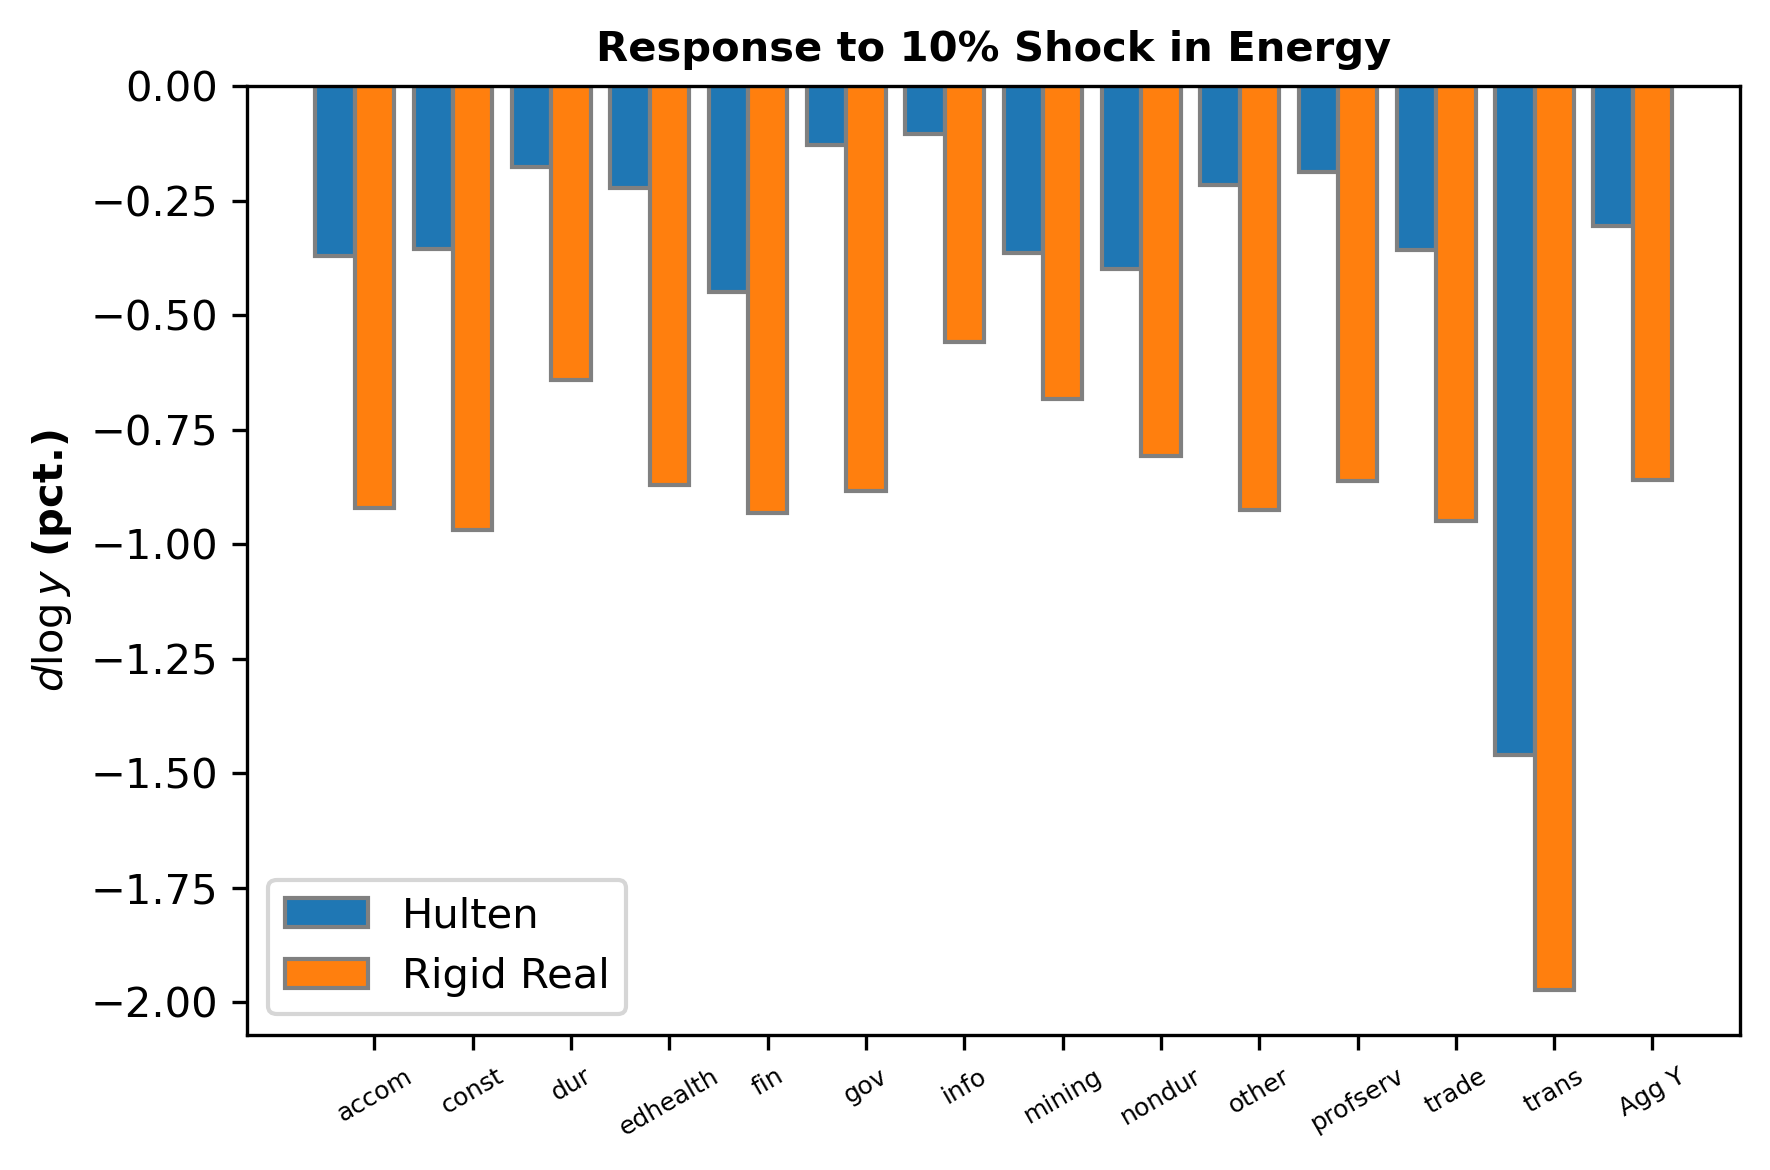

In [17]:
title = f'Response to 10% Shock in Energy'
xlab = ''
ylab = '$d\log y$ (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_KshockY_calib3.png'
labels = PriceAssumption
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

In [18]:
occupation_names

['Admin',
 'Agg',
 'Arts',
 'Bus Ops',
 'Care',
 'Clean',
 'Cons',
 'Educ',
 'Eng',
 'Food S',
 'Health P',
 'Health S',
 'Legal',
 'Manag',
 'Math',
 'Prod',
 'Prot S',
 'Repair',
 'Sales',
 'Science',
 'Soc S',
 'Trans']

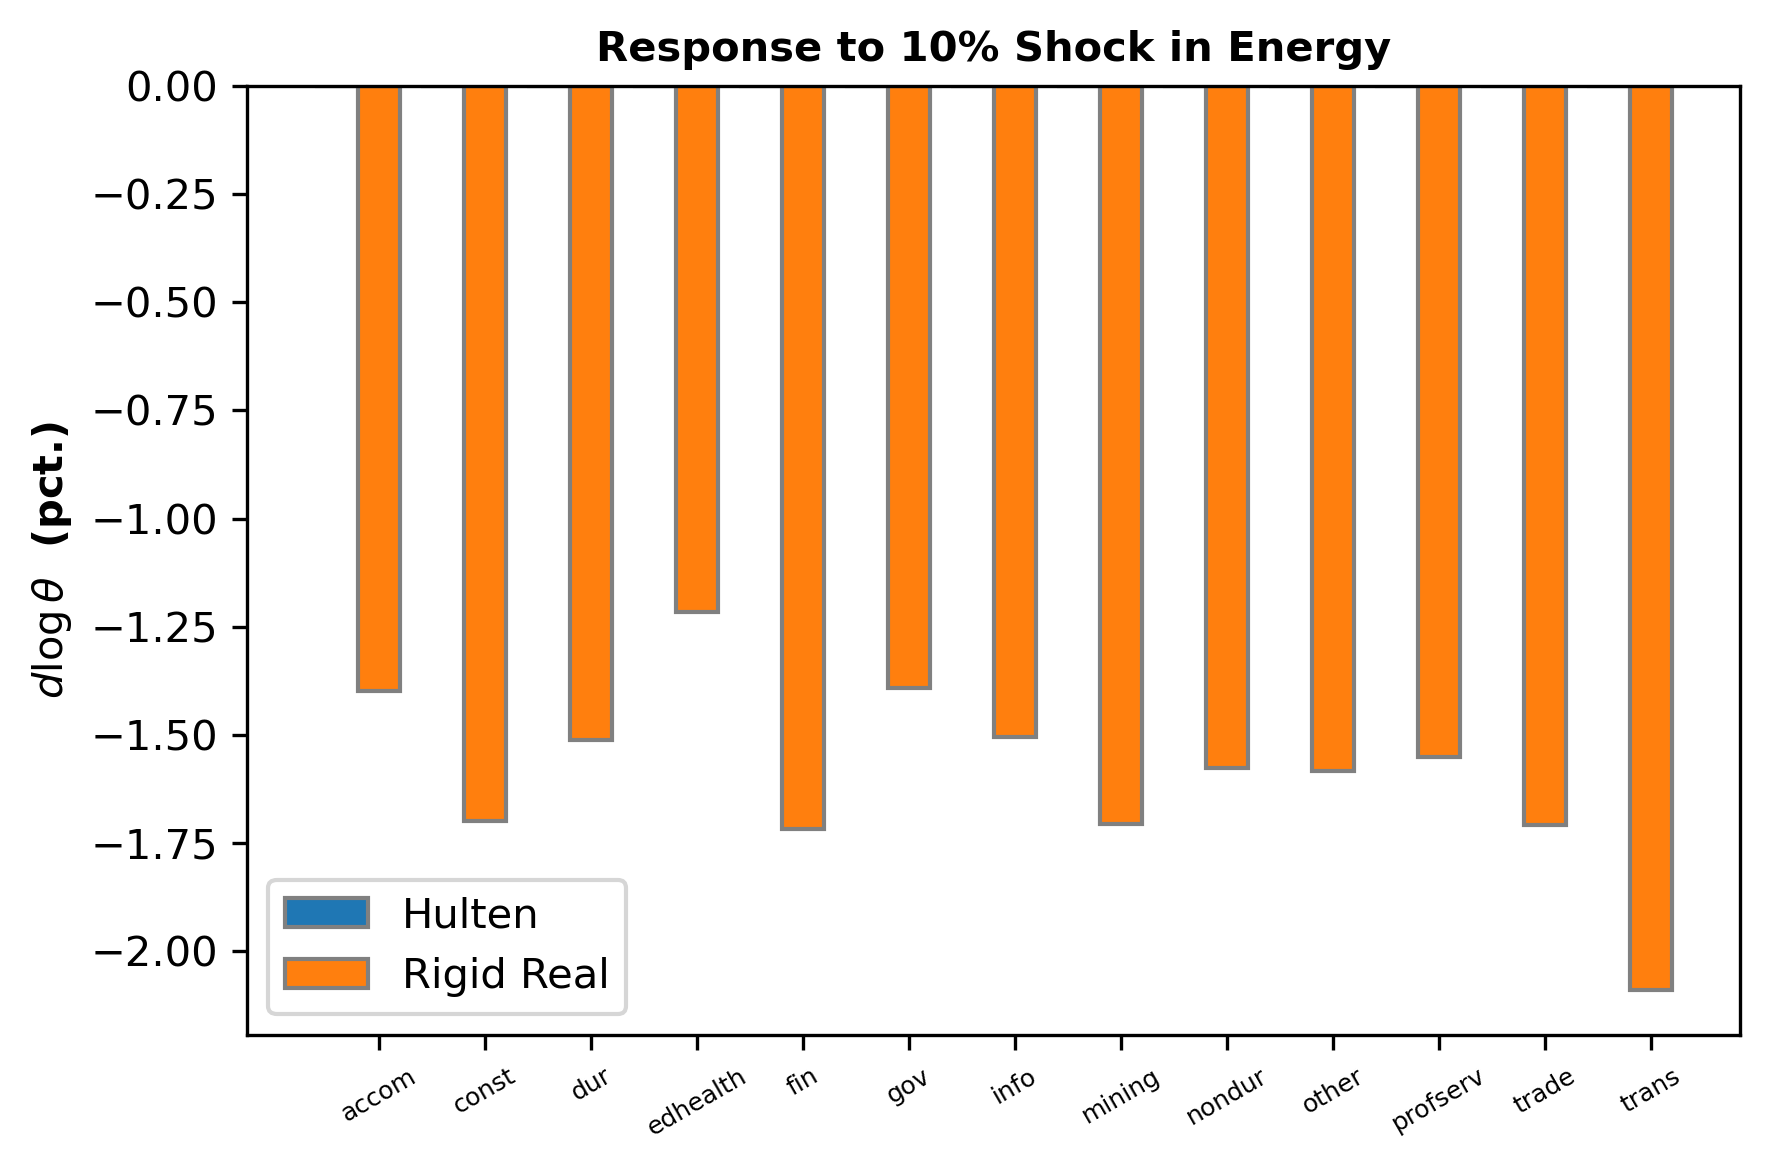

In [19]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_KshockTsec_calib3.png'
labels = PriceAssumption
bar_plot(100*secT_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

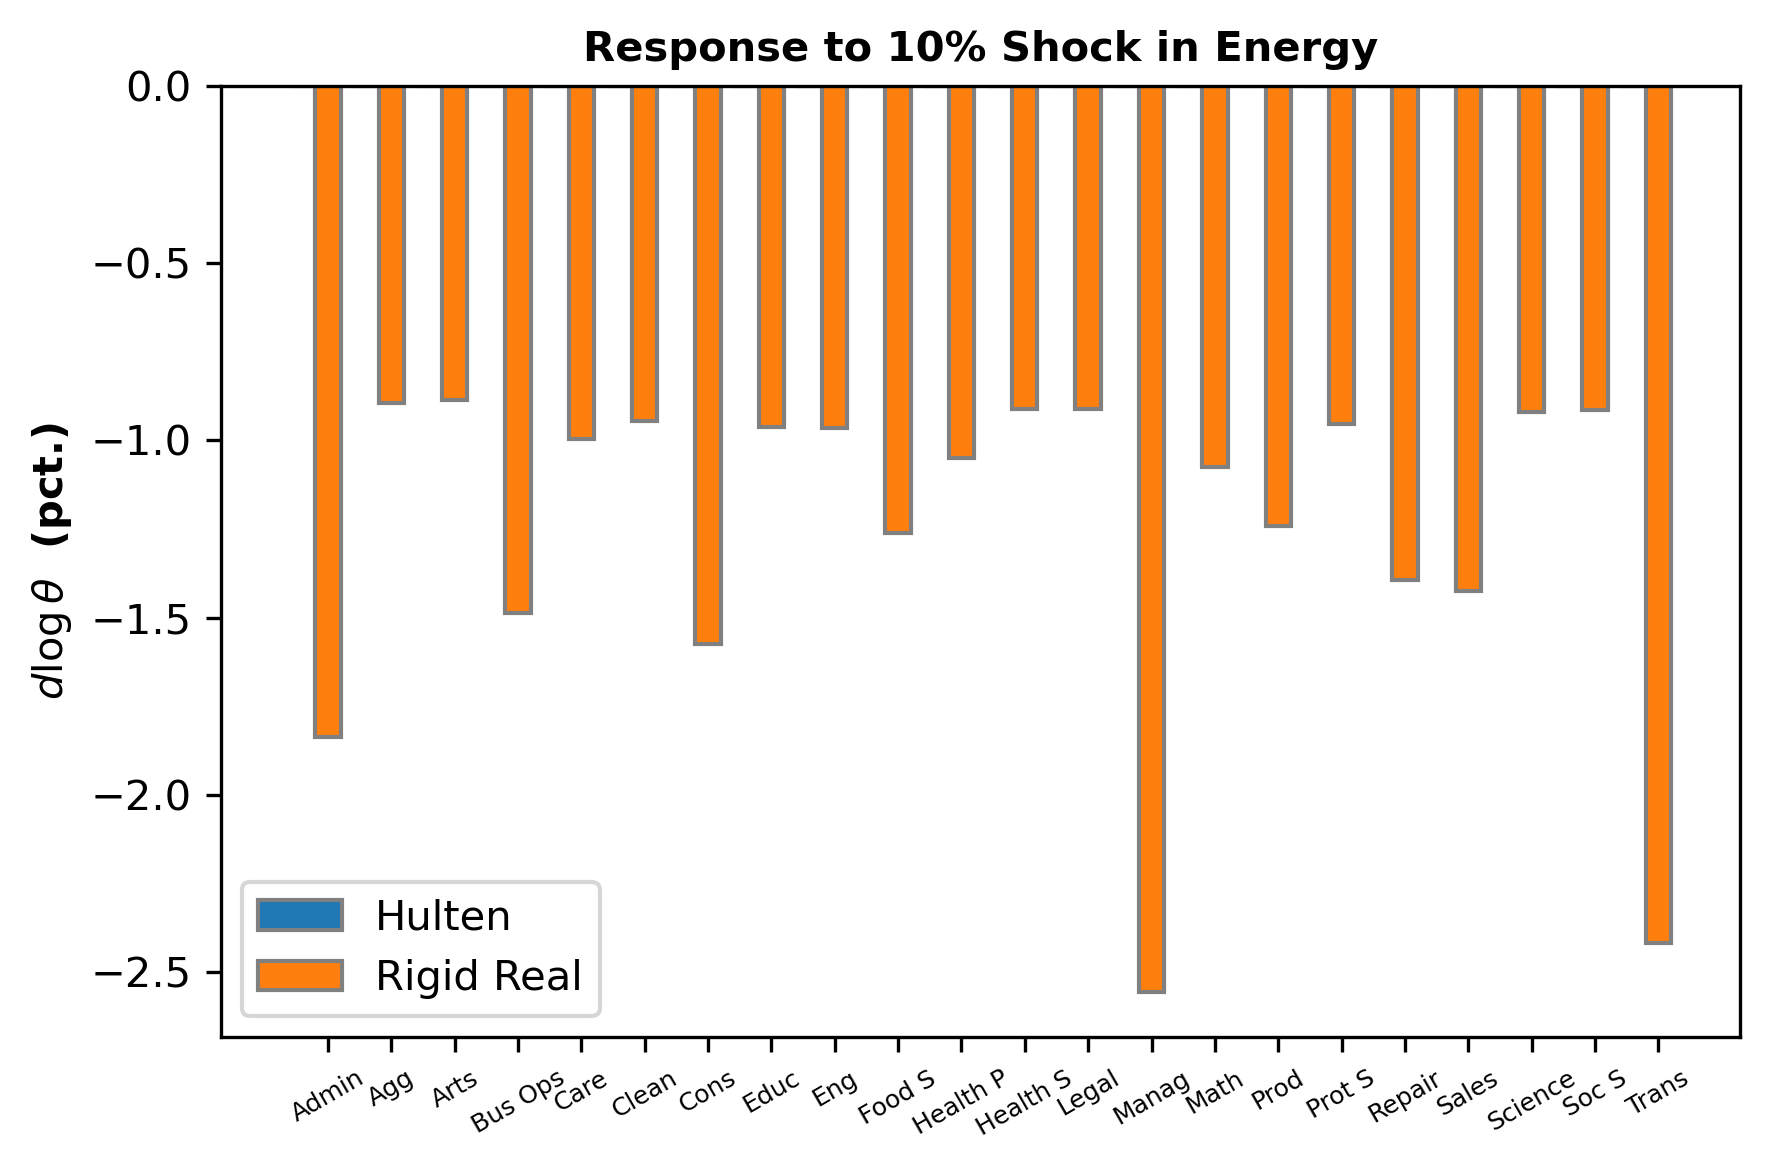

In [20]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_KshockT_calib3.png'
labels = PriceAssumption
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

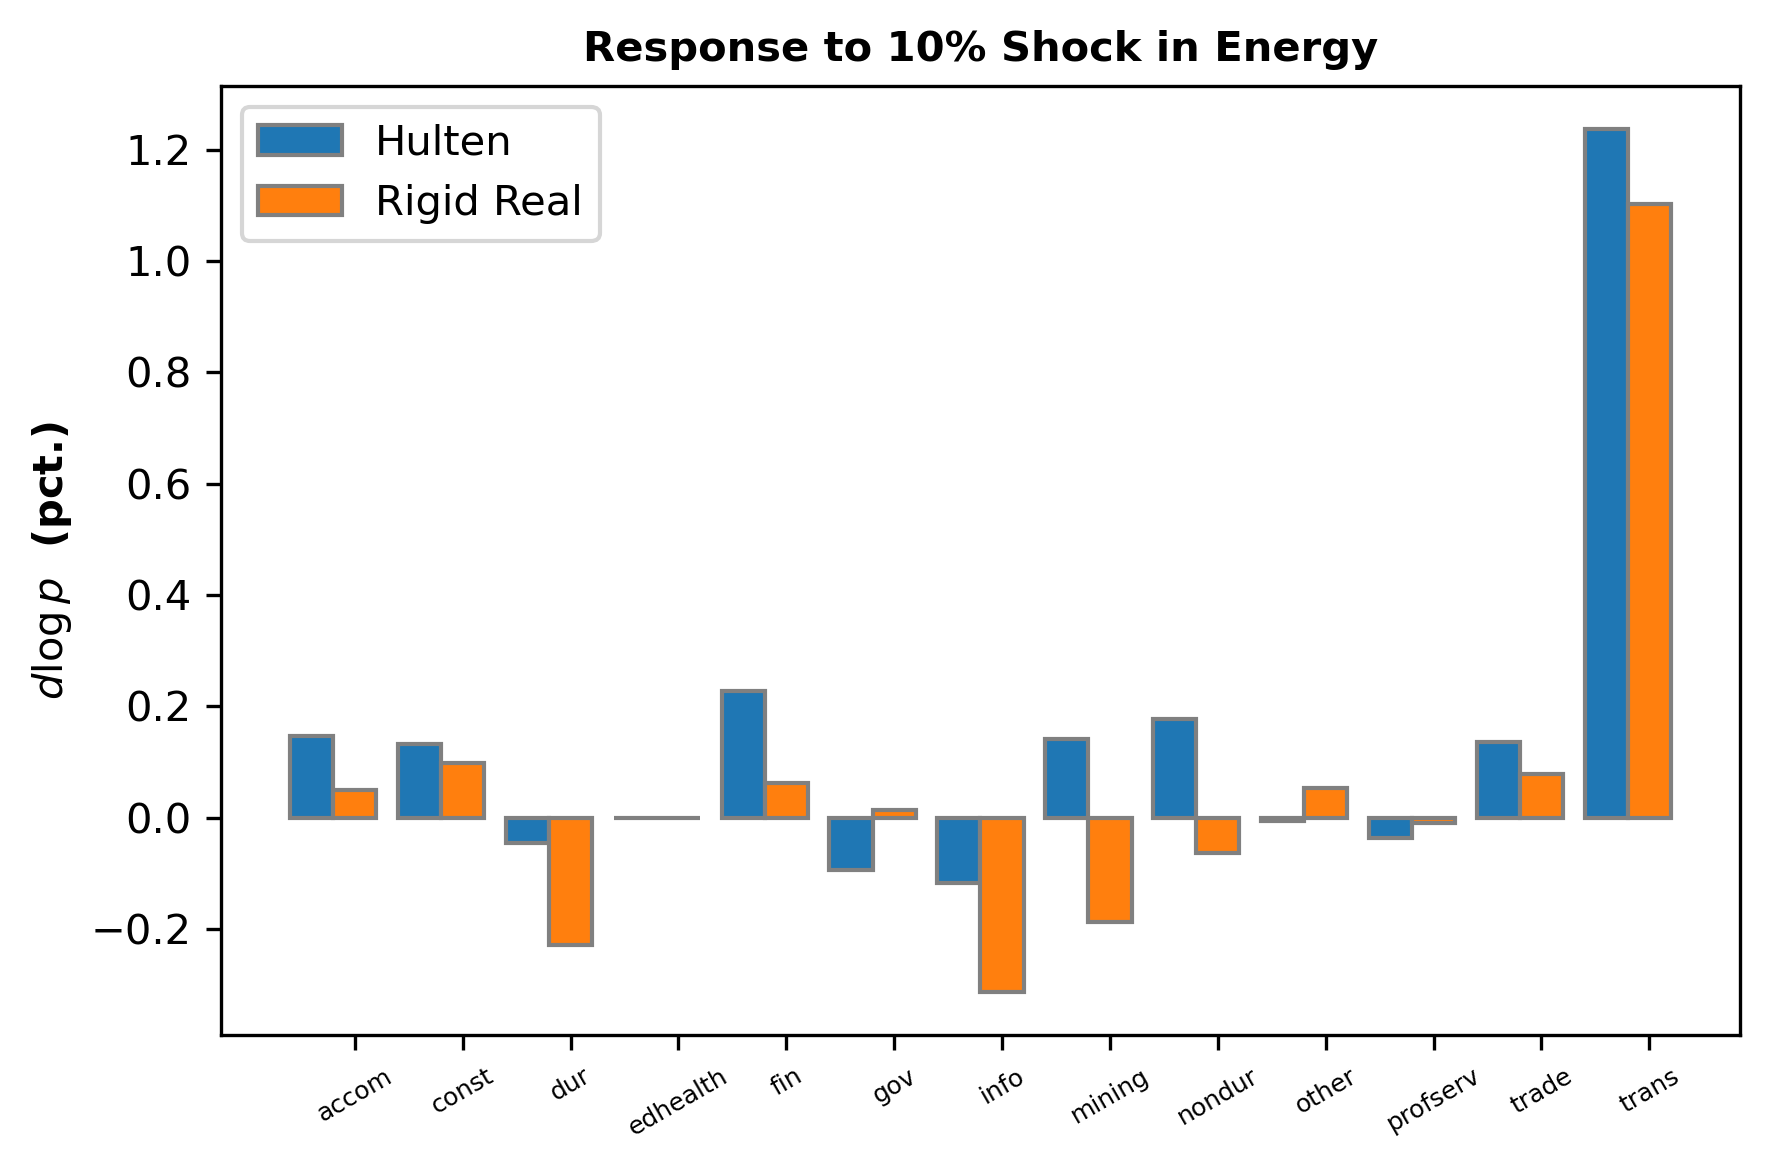

In [21]:
xlab = ''
ylab = '$d\log p$  (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_KshockP_calib3.png'
labels = PriceAssumption
bar_plot(100*p_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

## Labor Supply Shocks to Service Sectors

In [22]:
occupation_names

['Admin',
 'Agg',
 'Arts',
 'Bus Ops',
 'Care',
 'Clean',
 'Cons',
 'Educ',
 'Eng',
 'Food S',
 'Health P',
 'Health S',
 'Legal',
 'Manag',
 'Math',
 'Prod',
 'Prot S',
 'Repair',
 'Sales',
 'Science',
 'Soc S',
 'Trans']

In [23]:
occupation_names.index('Care')

4

In [24]:
dlog_A = np.zeros((J, 1))
dlog_H = np.zeros((O, 1))
dlog_K = np.zeros((K, 1))
service_sectors = ['Care', 'Clean', 'Food S', 'Trans']
shock_size = -0.02

for i in service_sectors:
    dlog_H[occupation_names.index(i)] = shock_size
dlog_lam = np.zeros_like(dlog_A)
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)
num = 3
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
PriceAssumption = ['Hulten', 'Rigid Real']
sectorY_vec = np.zeros((J+1,len(PriceAssumption)))
occT_vec = np.zeros((O, len(PriceAssumption)))
secT_vec = np.zeros((J, len(PriceAssumption)))

occU_vec = np.zeros((O, len(PriceAssumption)))
p_vec = np.zeros((J, len(PriceAssumption)))

In [25]:
epsWs = {'Hulten': multi_occupation_network.WageElasticityFunc(gamma_A=1, gamma_H=1, gamma_K=1, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK),
        '0.5MP': multi_occupation_network.WageElasticityFuncMP(0.5,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Rigid Real': multi_occupation_network.WageElasticityFuncMP(0,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Dampening': multi_occupation_network.WageElasticityFunc(gamma_A=1.5, gamma_H=1.5, gamma_K=1.5, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK)}
dlog_Ws = {}
for i in epsWs.keys():
    epsW_A, epsW_H, epsW_K = epsWs[i]
    dlog_Ws[i] = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    

In [26]:
for i, a in enumerate(PriceAssumption):
    if a == 'Rigid Nominal':
        dlog_p = nominal_rigidity_network.PriceFuncAlt(dlog_A=dlog_A, dlog_H=dlog_H, dlog_K=dlog_K, Psi=Psi, epsN=epsN, epsK=epsK, curlyQ=curlyQ, curlyT=curlyT, curlyF=curlyF, curlyL=curlyL, num=num)
        dlog_theta = nominal_rigidity_network.ThetaFuncAlt(dlog_H, dlog_A, dlog_K, dlog_p, Psi, epsN, epsK, curlyL, curlyQ, curlyT, curlyF, num=num)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = nominal_rigidity_network.rFunc(dlog_y, dlog_K, num)
    else:
        dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_Ws[a], dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
        dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_Ws[a], dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
    dlog_theta_sec = np.sum(np.multiply(dlog_theta.T, epsN_norm), axis=1)
    secT_vec[:, i] = dlog_theta_sec.flatten()
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    p_vec[:, i] = dlog_p.flatten()
    occT_vec[:, i] = dlog_theta.flatten()
    occU_vec[:, i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

In [27]:
np.multiply(dlog_theta.T, epsN_norm).shape

(13, 22)

In [28]:
np.sum(np.multiply(dlog_theta.T, epsN_norm), axis=1).shape

(13, 1)

In [29]:
epsN_norm[0, :]

array([4.34691670e-02, 3.16282806e-04, 2.44006371e-02, 2.15834194e-02,
       5.05546676e-02, 4.12221593e-02, 1.22011223e-03, 4.94621212e-03,
       3.28798077e-04, 6.22194023e-01, 1.50035597e-03, 8.92226917e-04,
       2.79215268e-04, 9.07721586e-02, 2.18710905e-03, 7.05521582e-03,
       1.09159248e-02, 1.89831374e-02, 3.71328184e-02, 3.40888390e-04,
       1.40323233e-04, 1.95651471e-02])

In [30]:
np.multiply(dlog_theta.T, epsN_norm[0, :])

matrix([[-9.42190677e-07, -3.90132209e-09, -2.68070581e-07,
         -3.66868974e-07,  1.11535956e-03,  8.76328933e-04,
         -1.98683191e-08, -4.85163698e-08, -4.00495977e-09,
          1.71339791e-02, -1.69129363e-08, -8.36959497e-09,
         -3.19380320e-09, -2.74278222e-06, -2.79685150e-08,
         -1.09412436e-07, -1.37395960e-07, -3.30269366e-07,
         -7.41326510e-07, -3.84031095e-09, -1.43542489e-09,
          7.50598614e-04]])

In [31]:
0.01978613 * 3.16282806

0.0625801271628078

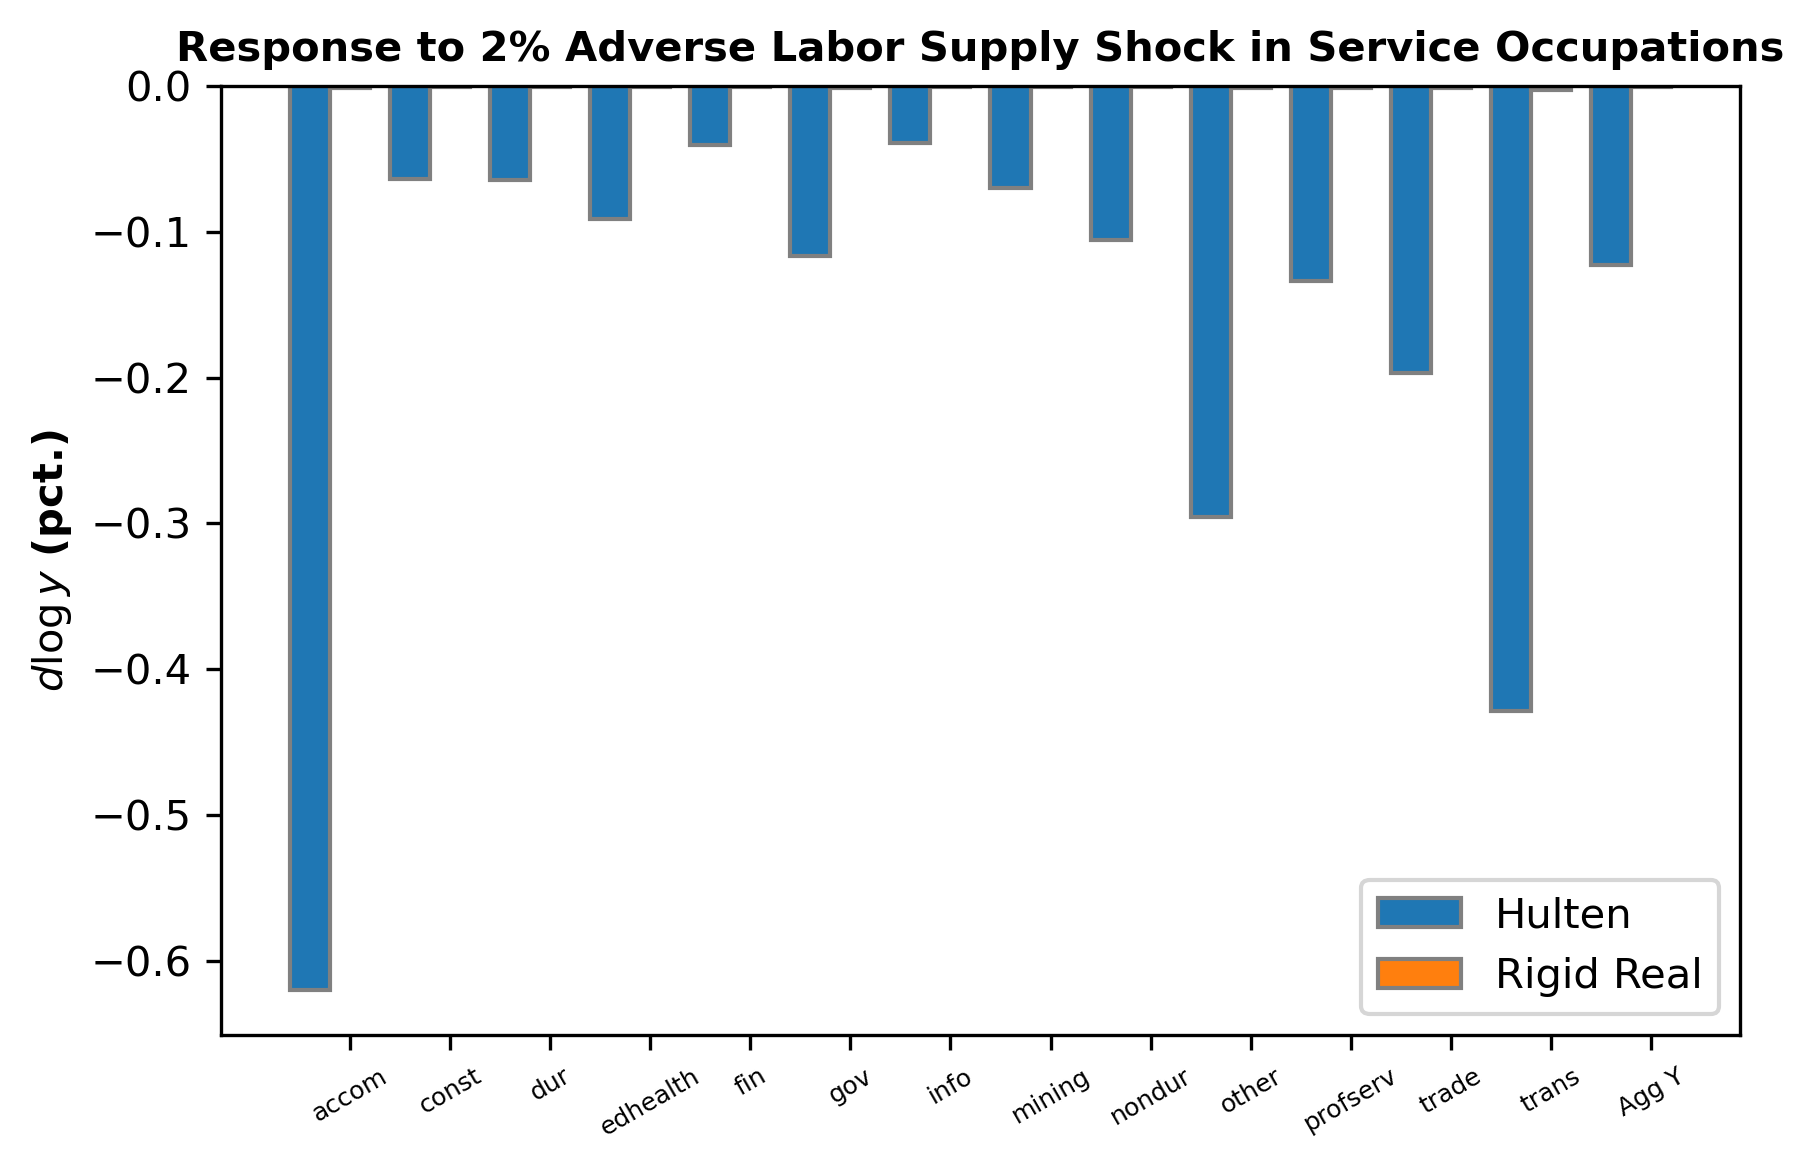

In [32]:
title = f'Response to 2% Adverse Labor Supply Shock in Service Occupations'
xlab = ''
ylab = '$d\log y$ (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_HservshockY_calib3.png'
labels = PriceAssumption
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

In [33]:
occupation_names

['Admin',
 'Agg',
 'Arts',
 'Bus Ops',
 'Care',
 'Clean',
 'Cons',
 'Educ',
 'Eng',
 'Food S',
 'Health P',
 'Health S',
 'Legal',
 'Manag',
 'Math',
 'Prod',
 'Prot S',
 'Repair',
 'Sales',
 'Science',
 'Soc S',
 'Trans']

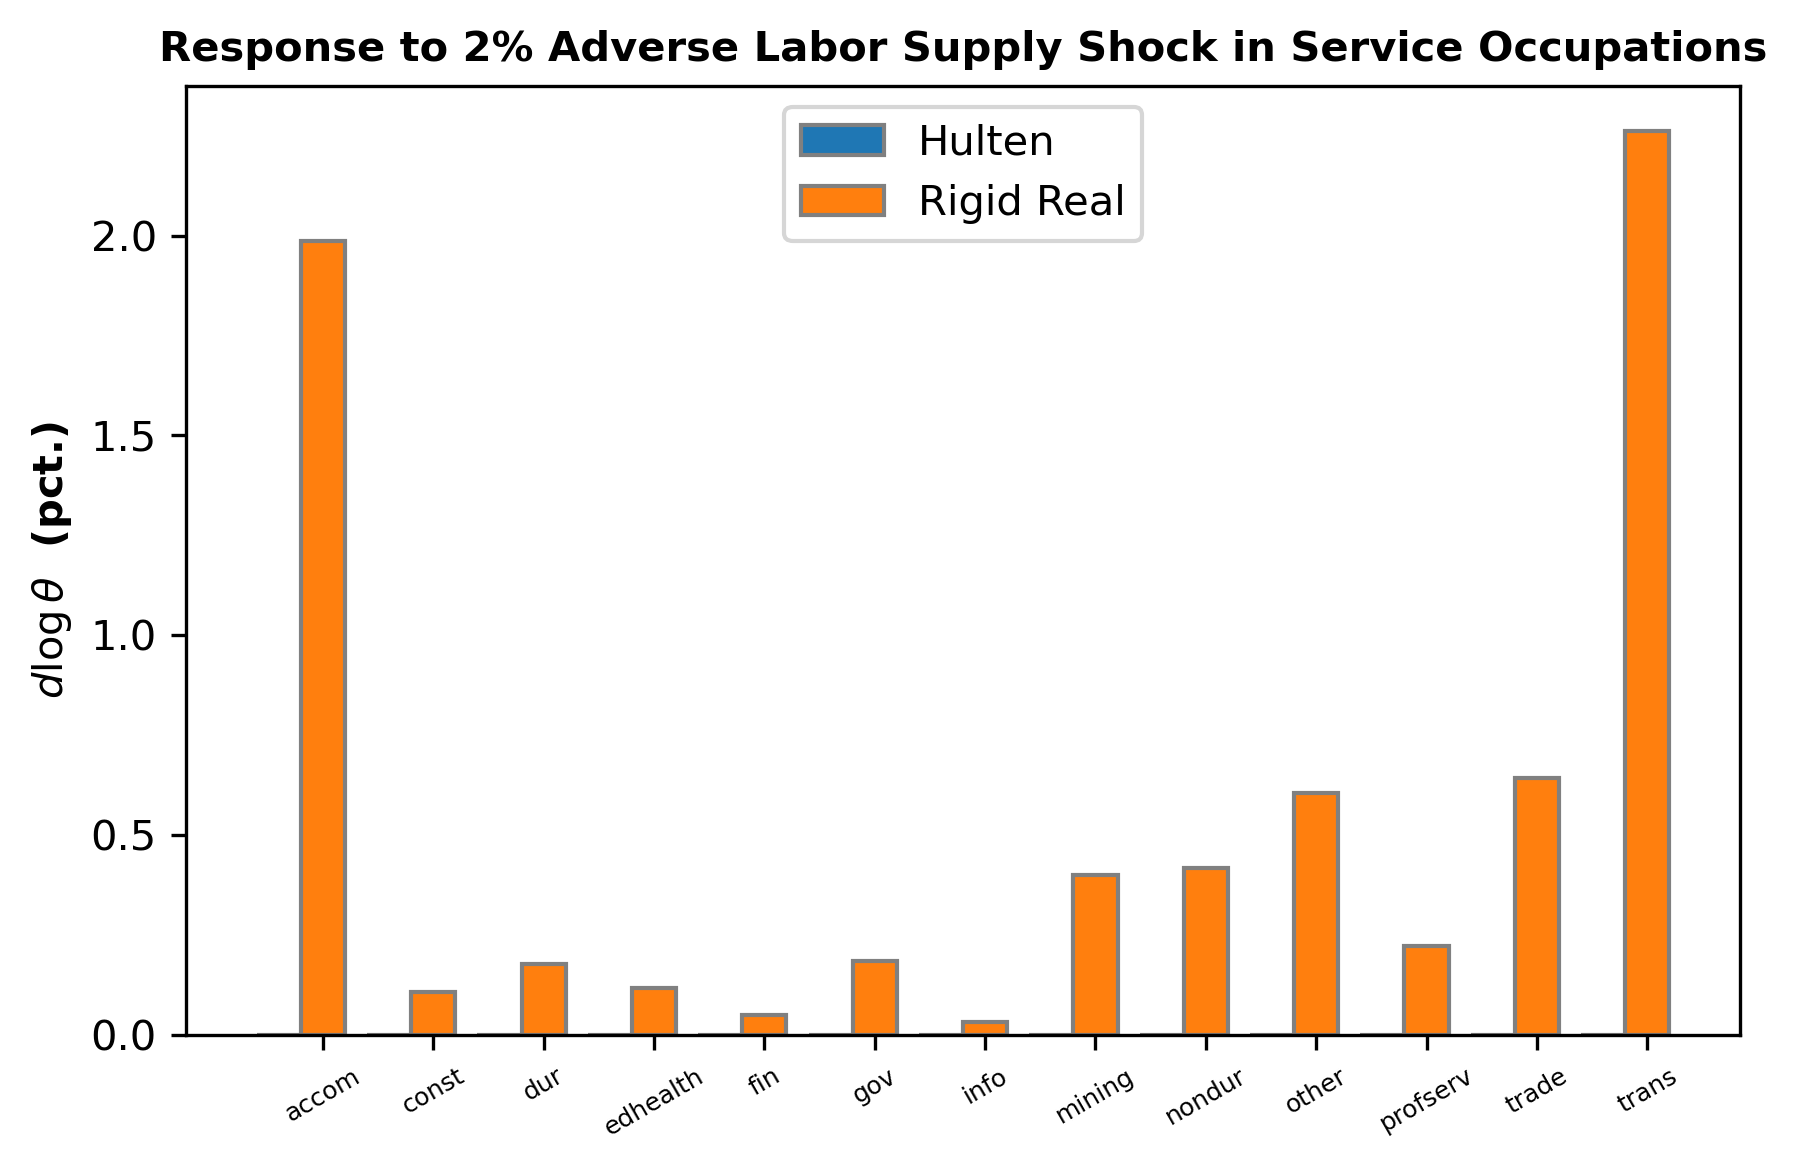

In [34]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_HservshockTsec_calib3.png'
labels = PriceAssumption
bar_plot(100*secT_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth=0.40, dpi=300)

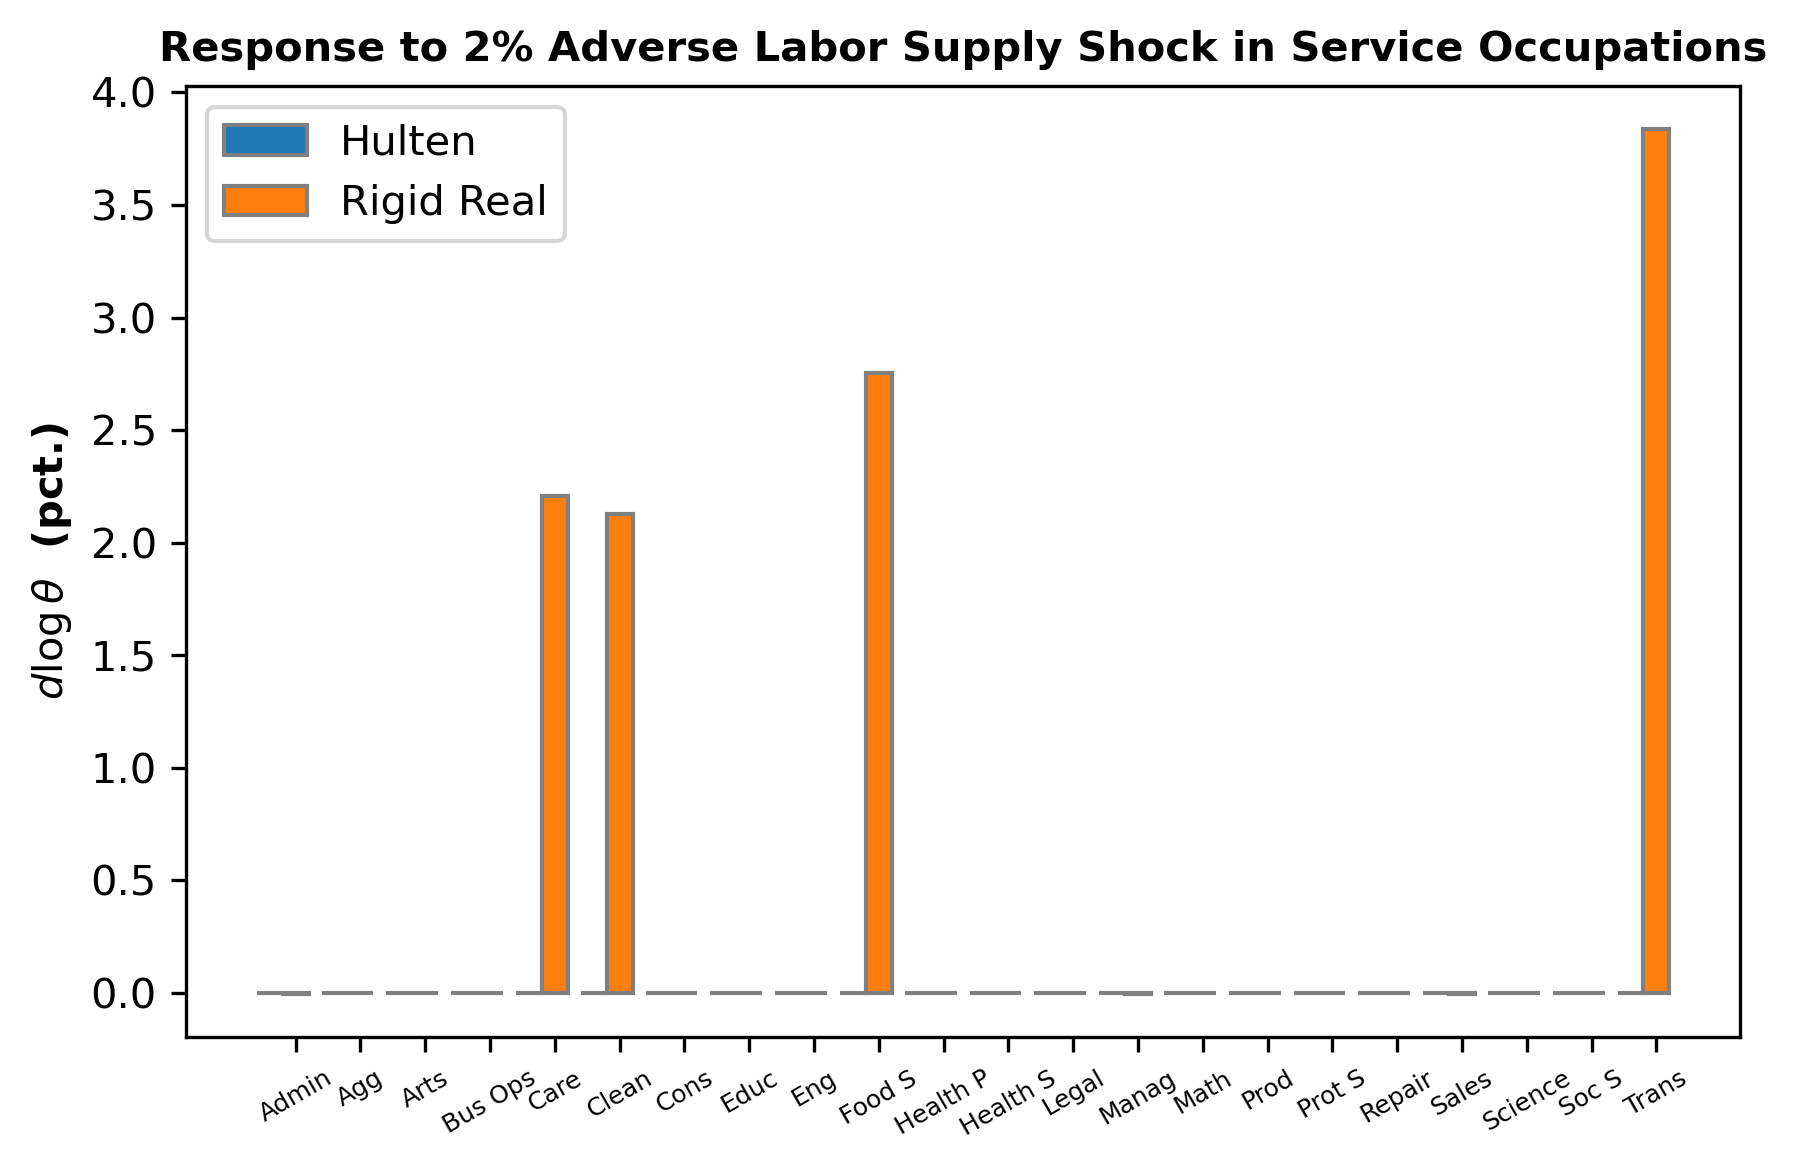

In [35]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_HservshockT_calib3.png'
labels = PriceAssumption
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

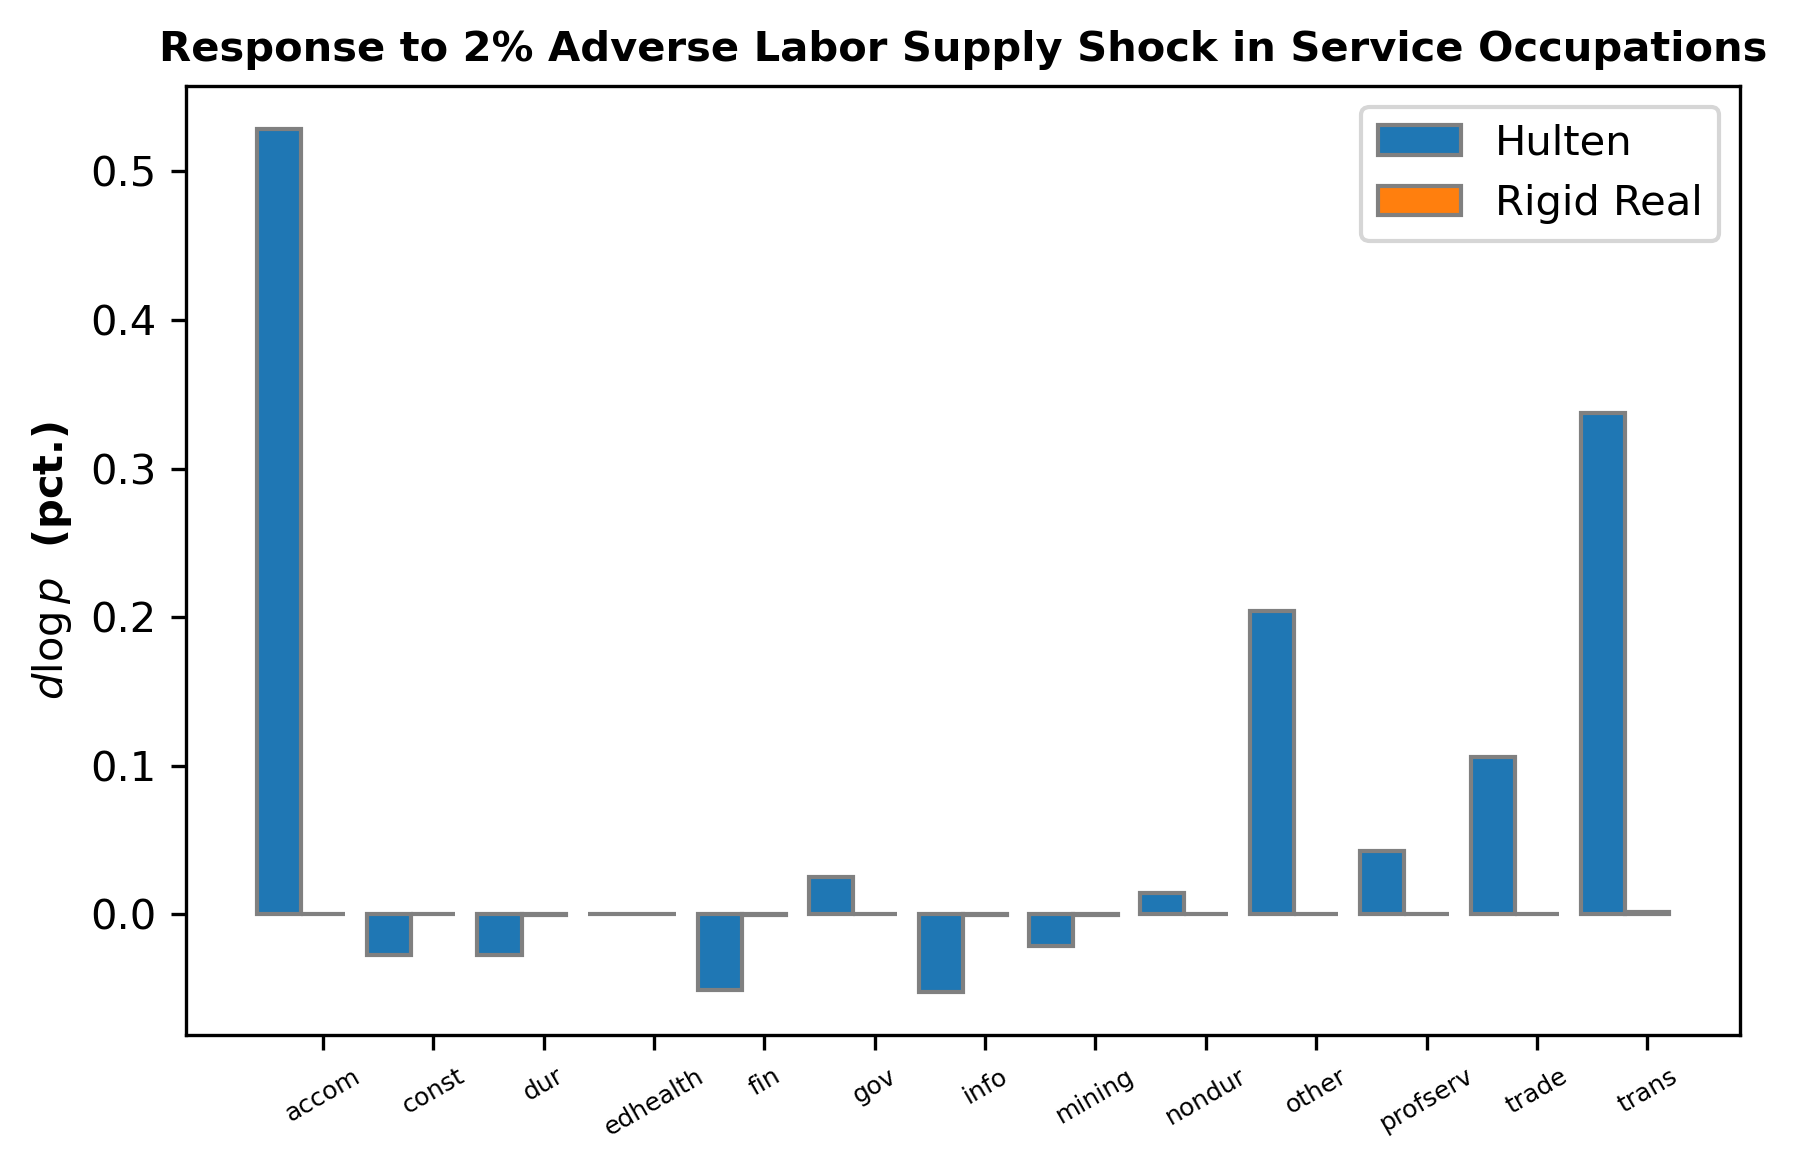

In [36]:
xlab = ''
ylab = '$d\log p$  (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_HservshockP_calib3.png'
labels = PriceAssumption
bar_plot(100*p_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

## Calibration figures: Response to Labor Supply Shock

### Aggregate importance of deviations from Hulten.

To analyse the quantitative importance of deviations from Hulten's theorem, below we vary $\gamma_A$ from 0 to 2, and plot the aggregate response to a 1\% shock to durable goods.

In [37]:
dlog_A = np.zeros((J, 1))
dlog_H = np.ones((O, 1)) * -0.02
dlog_K = np.zeros((K, 1))
dlog_lam = np.zeros_like(dlog_A)
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)
num = 3
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
PriceAssumption = ['Hulten', 'Rigid Real']
sectorY_vec = np.zeros((J+1,len(PriceAssumption)))
occT_vec = np.zeros((O, len(PriceAssumption)))
secT_vec = np.zeros((J, len(PriceAssumption))) 
occU_vec = np.zeros((O, len(PriceAssumption)))
p_vec = np.zeros((J, len(PriceAssumption)))

In [38]:
epsWs = {'Hulten': multi_occupation_network.WageElasticityFunc(gamma_A=1, gamma_H=1, gamma_K=1, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK),
        '0.5MP': multi_occupation_network.WageElasticityFuncMP(0.5,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Rigid Real': multi_occupation_network.WageElasticityFuncMP(0,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Dampening': multi_occupation_network.WageElasticityFunc(gamma_A=1.5, gamma_H=1.5, gamma_K=1.5, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK)}
dlog_Ws = {}
for i in epsWs.keys():
    epsW_A, epsW_H, epsW_K = epsWs[i]
    dlog_Ws[i] = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    

In [39]:
for i, a in enumerate(PriceAssumption):
    if a == 'Rigid Nominal':
        dlog_p = nominal_rigidity_network.PriceFuncAlt(dlog_A=dlog_A, dlog_H=dlog_H, dlog_K=dlog_K, Psi=Psi, epsN=epsN, epsK=epsK, curlyQ=curlyQ, curlyT=curlyT, curlyF=curlyF, curlyL=curlyL, num=num)
        dlog_theta = nominal_rigidity_network.ThetaFuncAlt(dlog_H, dlog_A, dlog_K, dlog_p, Psi, epsN, epsK, curlyL, curlyQ, curlyT, curlyF, num=num)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = nominal_rigidity_network.rFunc(dlog_y, dlog_K, num)
    else:
        dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_Ws[a], dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
        dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_Ws[a], dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
    dlog_theta_sec = np.sum(np.multiply(dlog_theta.T, epsN_norm), axis=1)
    secT_vec[:, i] = dlog_theta_sec.flatten()
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    p_vec[:, i] = dlog_p.flatten()
    occT_vec[:, i] = dlog_theta.flatten()
    occU_vec[:, i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

In [40]:
sectorY_vec.shape

(14, 2)

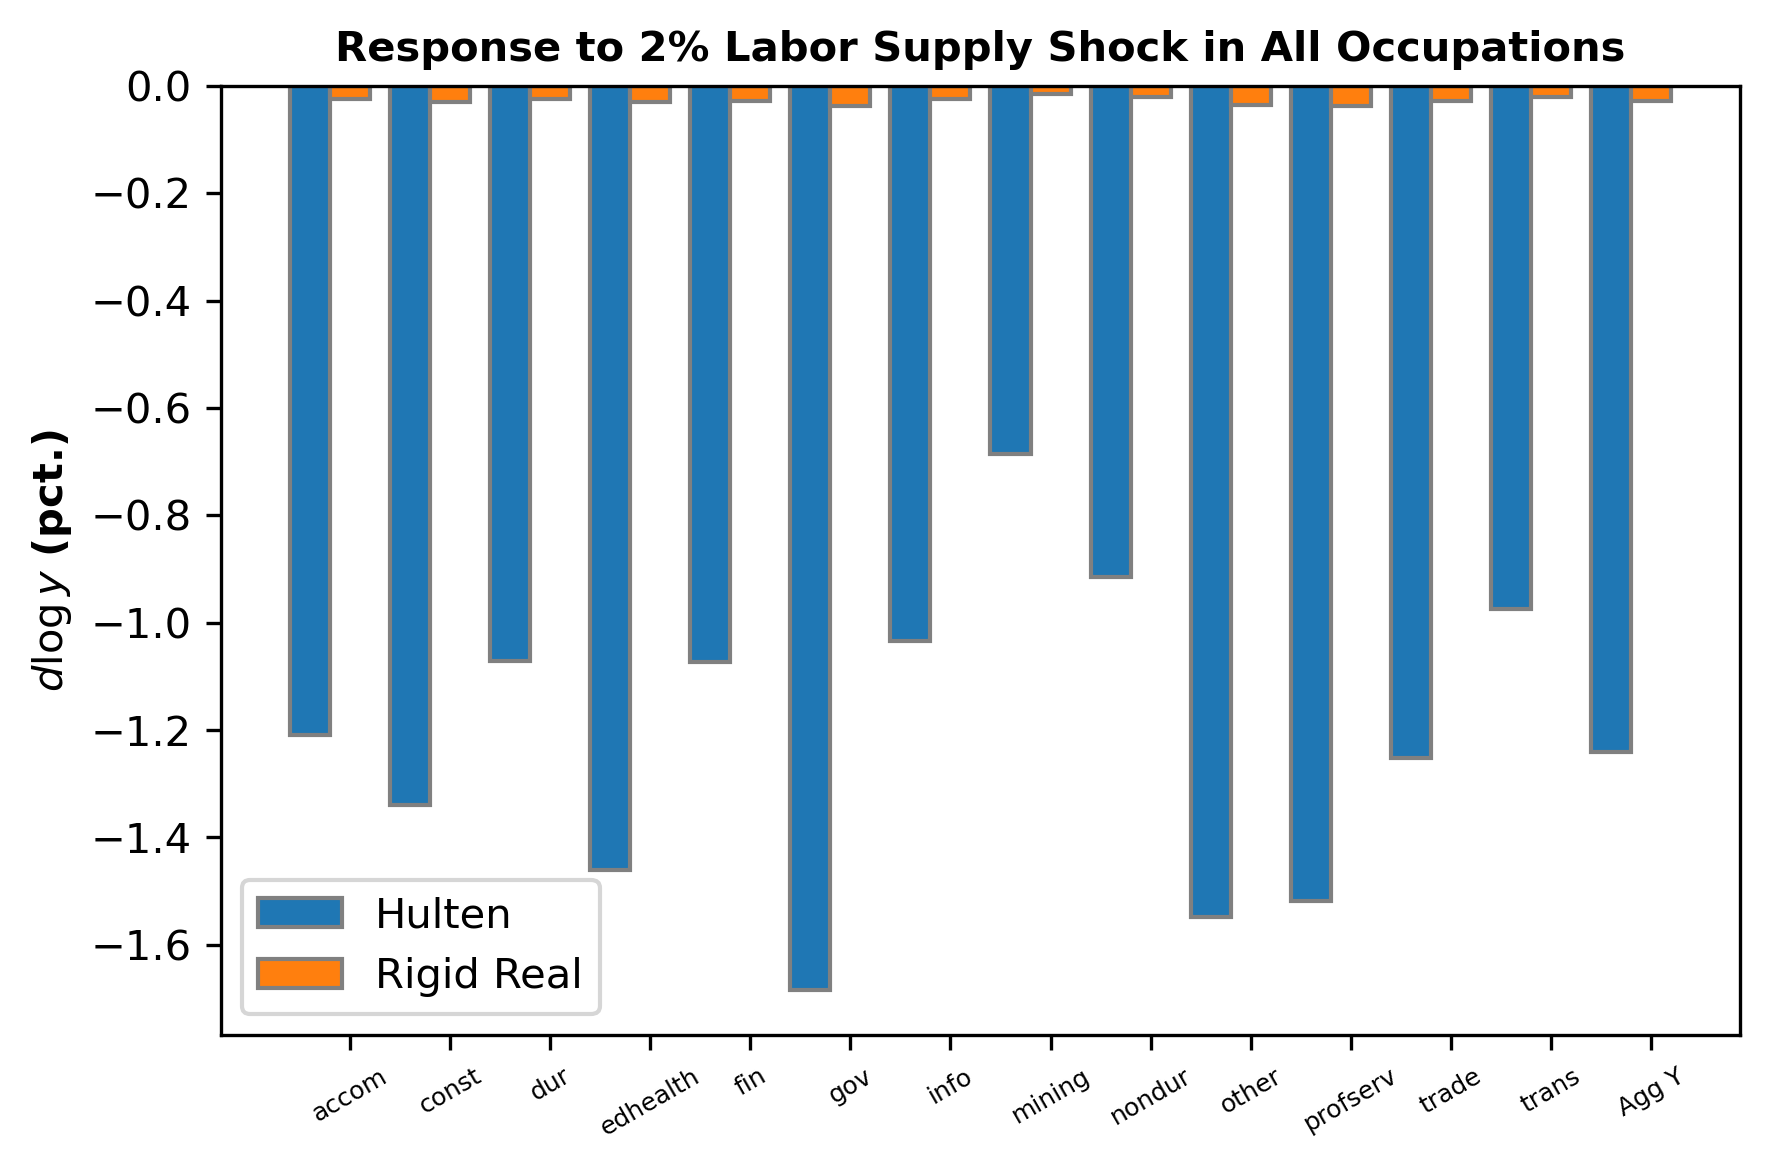

In [41]:
title = f'Response to 2% Labor Supply Shock in All Occupations'
xlab = ''
ylab = '$d\log y$ (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_HallshockY_calib3.png'
labels = PriceAssumption
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

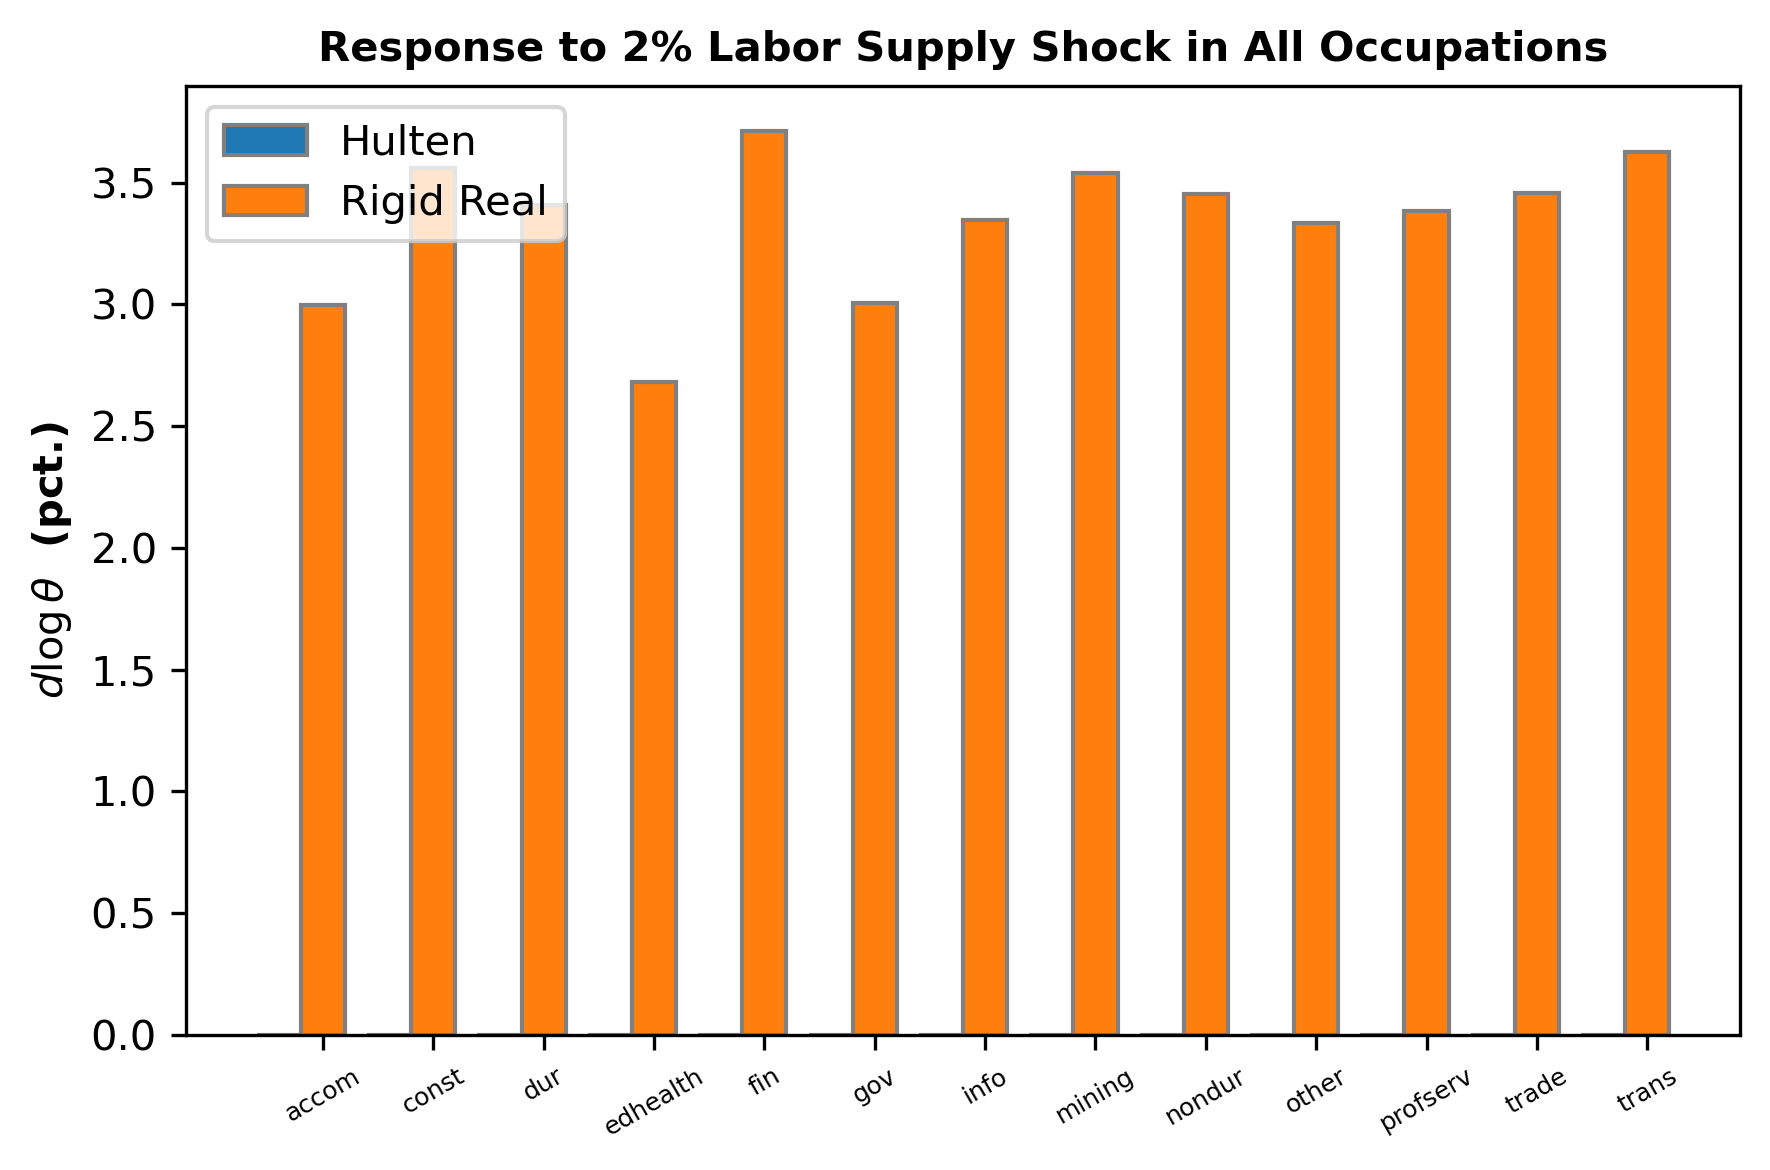

In [42]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_HallshockTsec_calib3.png'
labels = PriceAssumption
bar_plot(100*secT_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

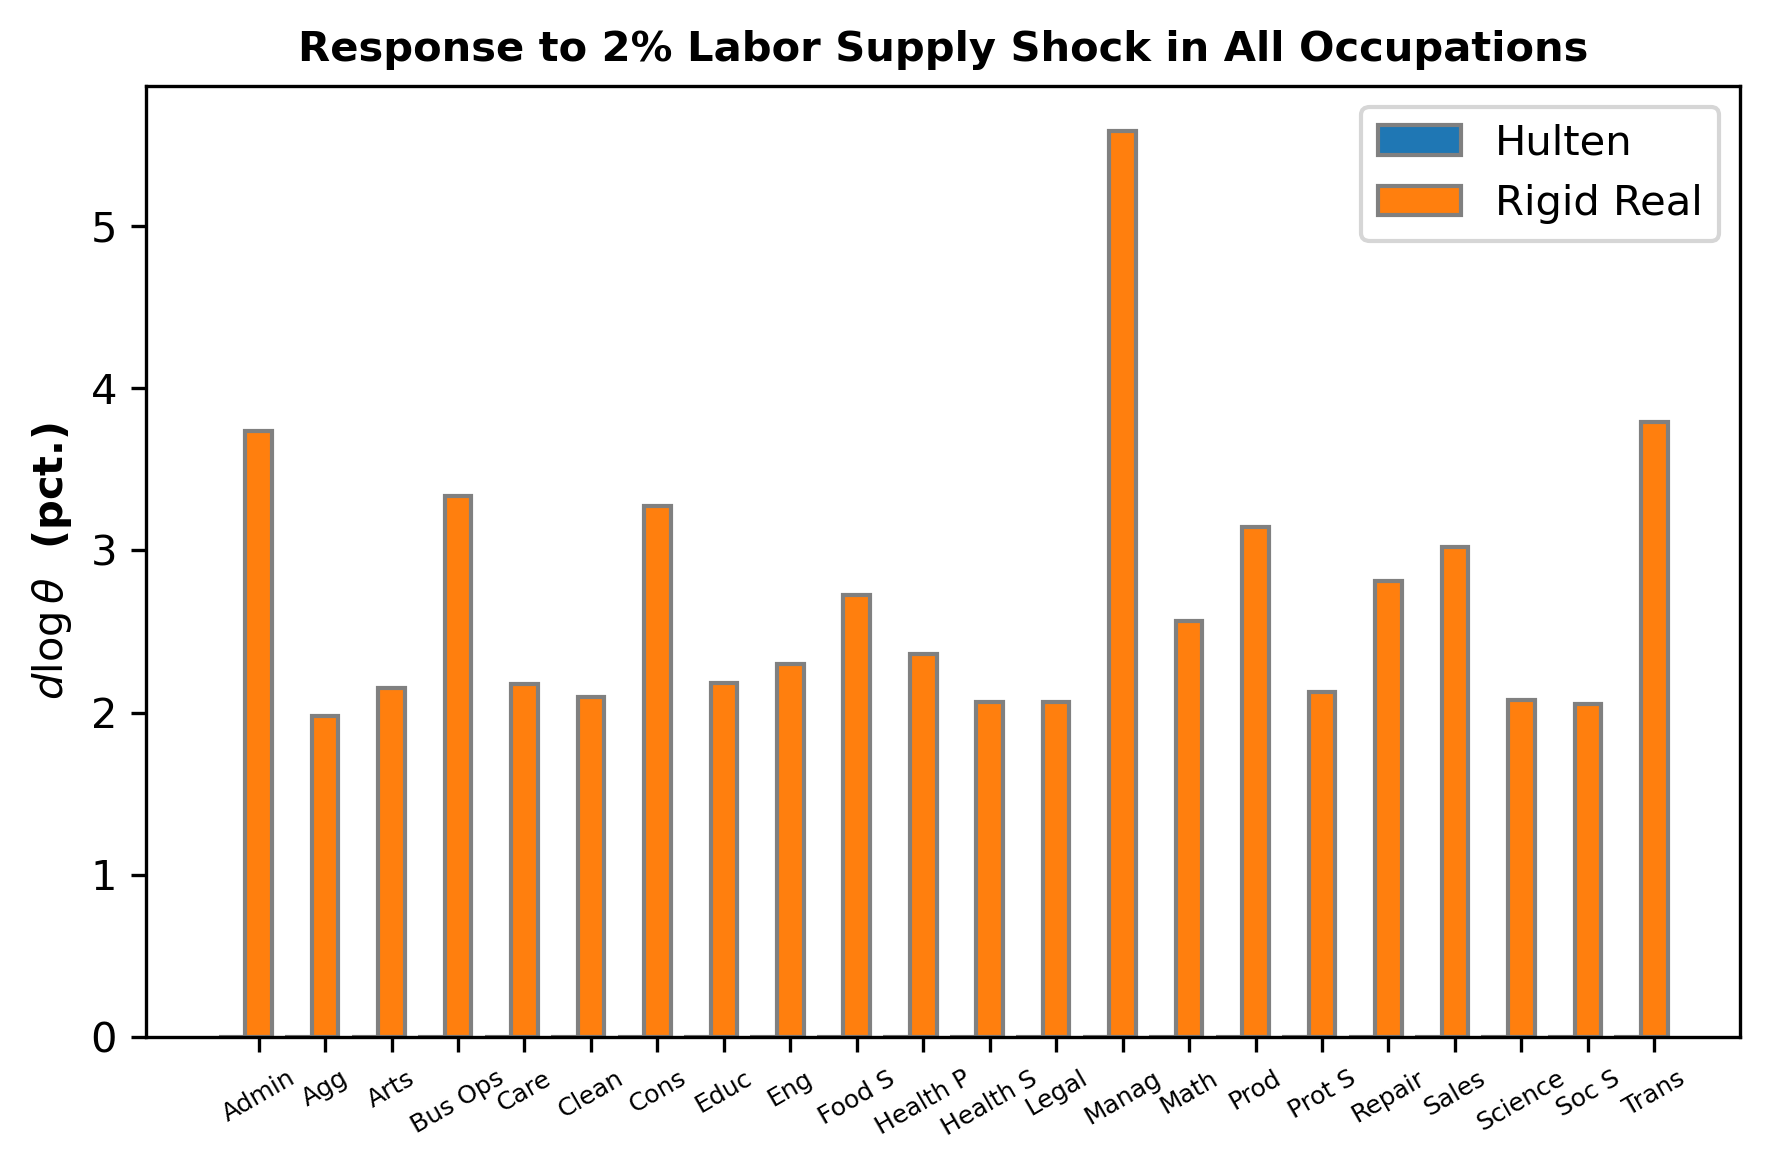

In [43]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_HallshockT_calib3.png'
labels = PriceAssumption
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

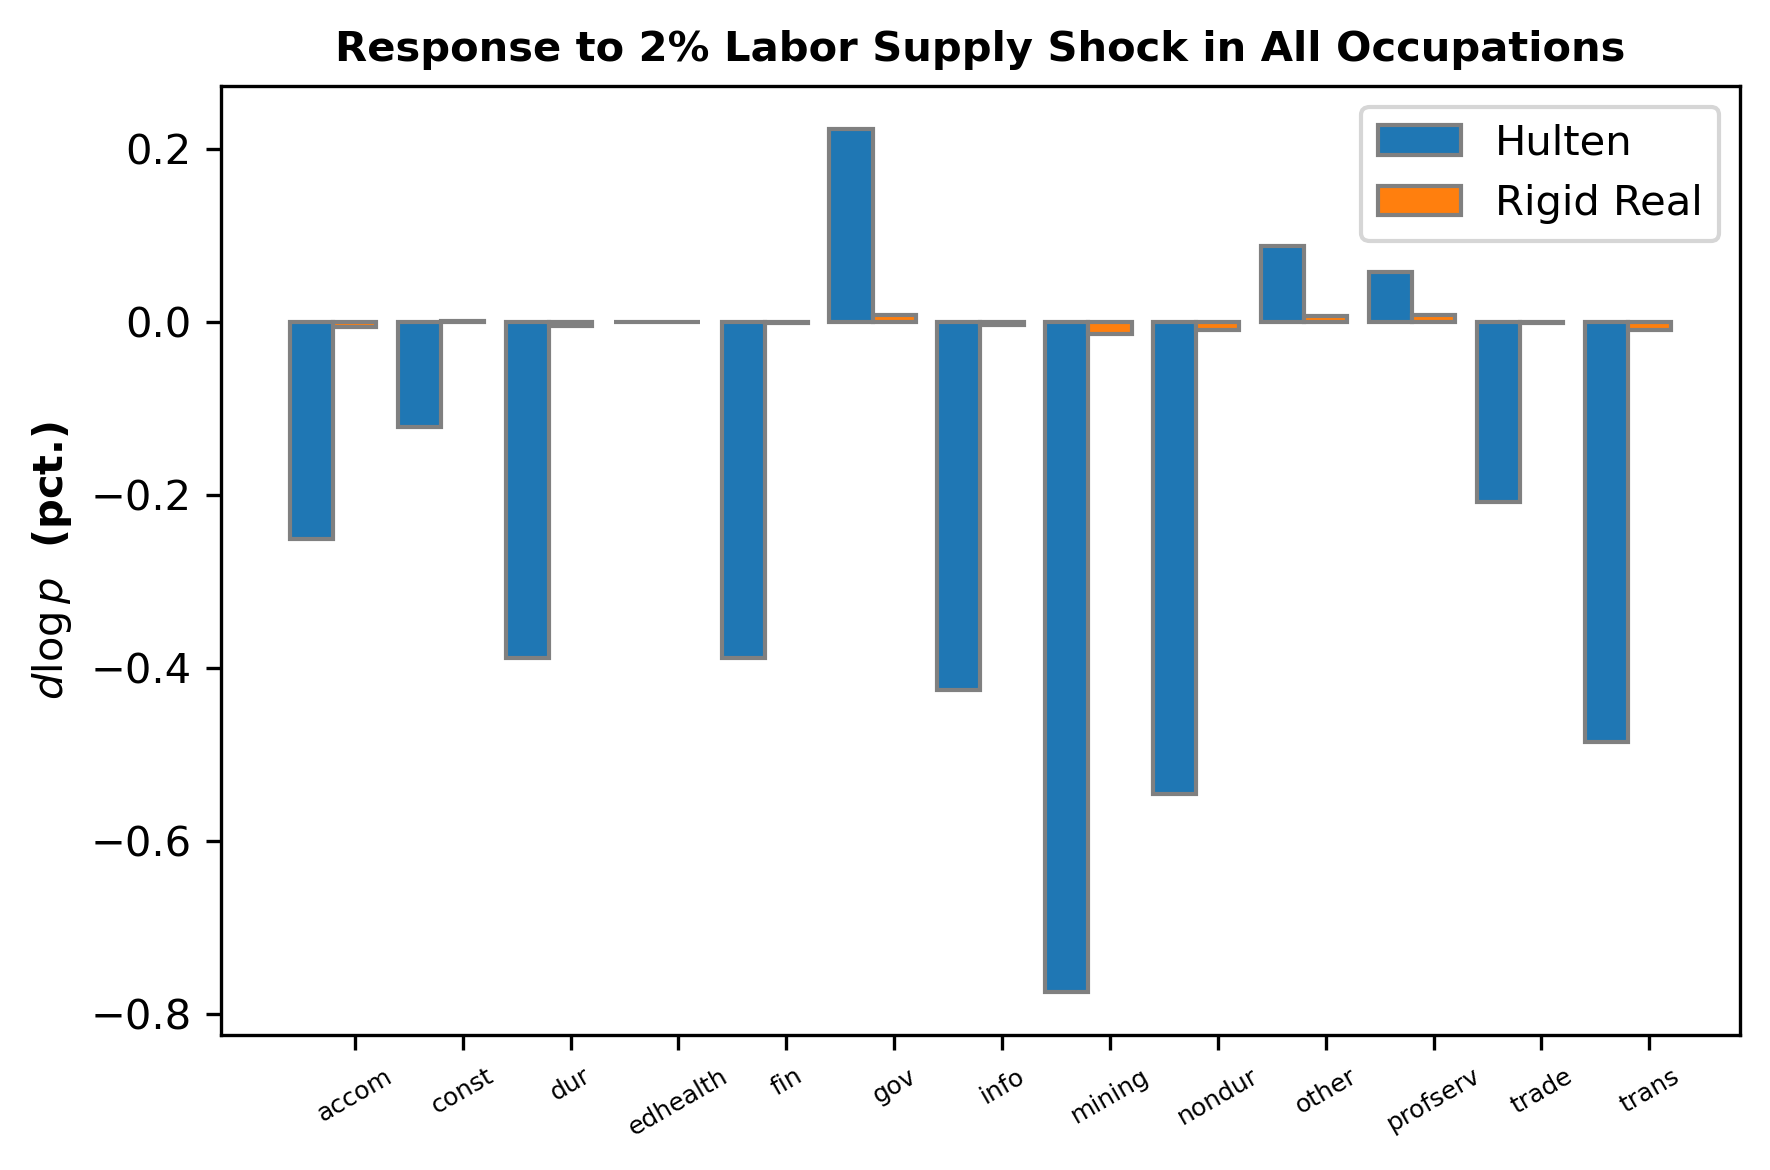

In [44]:
xlab = ''
ylab = '$d\log p$  (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_HallshockP_calib3.png'
labels = PriceAssumption
bar_plot(100*p_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

# Combination Shocks

In [45]:
dlog_A = np.zeros((J, 1))
dlog_H = np.ones((O, 1)) * -0.02
dlog_K = np.zeros((K, 1))
dlog_K[1] = -0.1
dlog_lam = np.zeros_like(dlog_A)
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)
num = 3
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
PriceAssumption = ['Hulten', 'Rigid Real']
sectorY_vec = np.zeros((J+1,len(PriceAssumption)))
secT_vec = np.zeros((J,len(PriceAssumption)))
occT_vec = np.zeros((O, len(PriceAssumption)))
occU_vec = np.zeros((O, len(PriceAssumption)))
p_vec = np.zeros((J, len(PriceAssumption)))

In [46]:
epsWs = {'Hulten': multi_occupation_network.WageElasticityFunc(gamma_A=1, gamma_H=1, gamma_K=1, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK),
        '0.5MP': multi_occupation_network.WageElasticityFuncMP(0.5,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Rigid Real': multi_occupation_network.WageElasticityFuncMP(0,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Dampening': multi_occupation_network.WageElasticityFunc(gamma_A=1.5, gamma_H=1.5, gamma_K=1.5, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK)}
dlog_Ws = {}
for i in epsWs.keys():
    epsW_A, epsW_H, epsW_K = epsWs[i]
    dlog_Ws[i] = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    

In [47]:
for i, a in enumerate(PriceAssumption):
    if a == 'Rigid Nominal':
        dlog_p = nominal_rigidity_network.PriceFuncAlt(dlog_A=dlog_A, dlog_H=dlog_H, dlog_K=dlog_K, Psi=Psi, epsN=epsN, epsK=epsK, curlyQ=curlyQ, curlyT=curlyT, curlyF=curlyF, curlyL=curlyL, num=num)
        dlog_theta = nominal_rigidity_network.ThetaFuncAlt(dlog_H, dlog_A, dlog_K, dlog_p, Psi, epsN, epsK, curlyL, curlyQ, curlyT, curlyF, num=num)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = nominal_rigidity_network.rFunc(dlog_y, dlog_K, num)
    else:
        dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_Ws[a], dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
        dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_Ws[a], dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
    dlog_theta_sec = np.sum(np.multiply(dlog_theta.T, epsN_norm), axis=1)
    secT_vec[:, i] = dlog_theta_sec.flatten()
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    p_vec[:, i] = dlog_p.flatten()
    occT_vec[:, i] = dlog_theta.flatten()
    occU_vec[:, i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

In [48]:
sectorY_vec.shape

(14, 2)

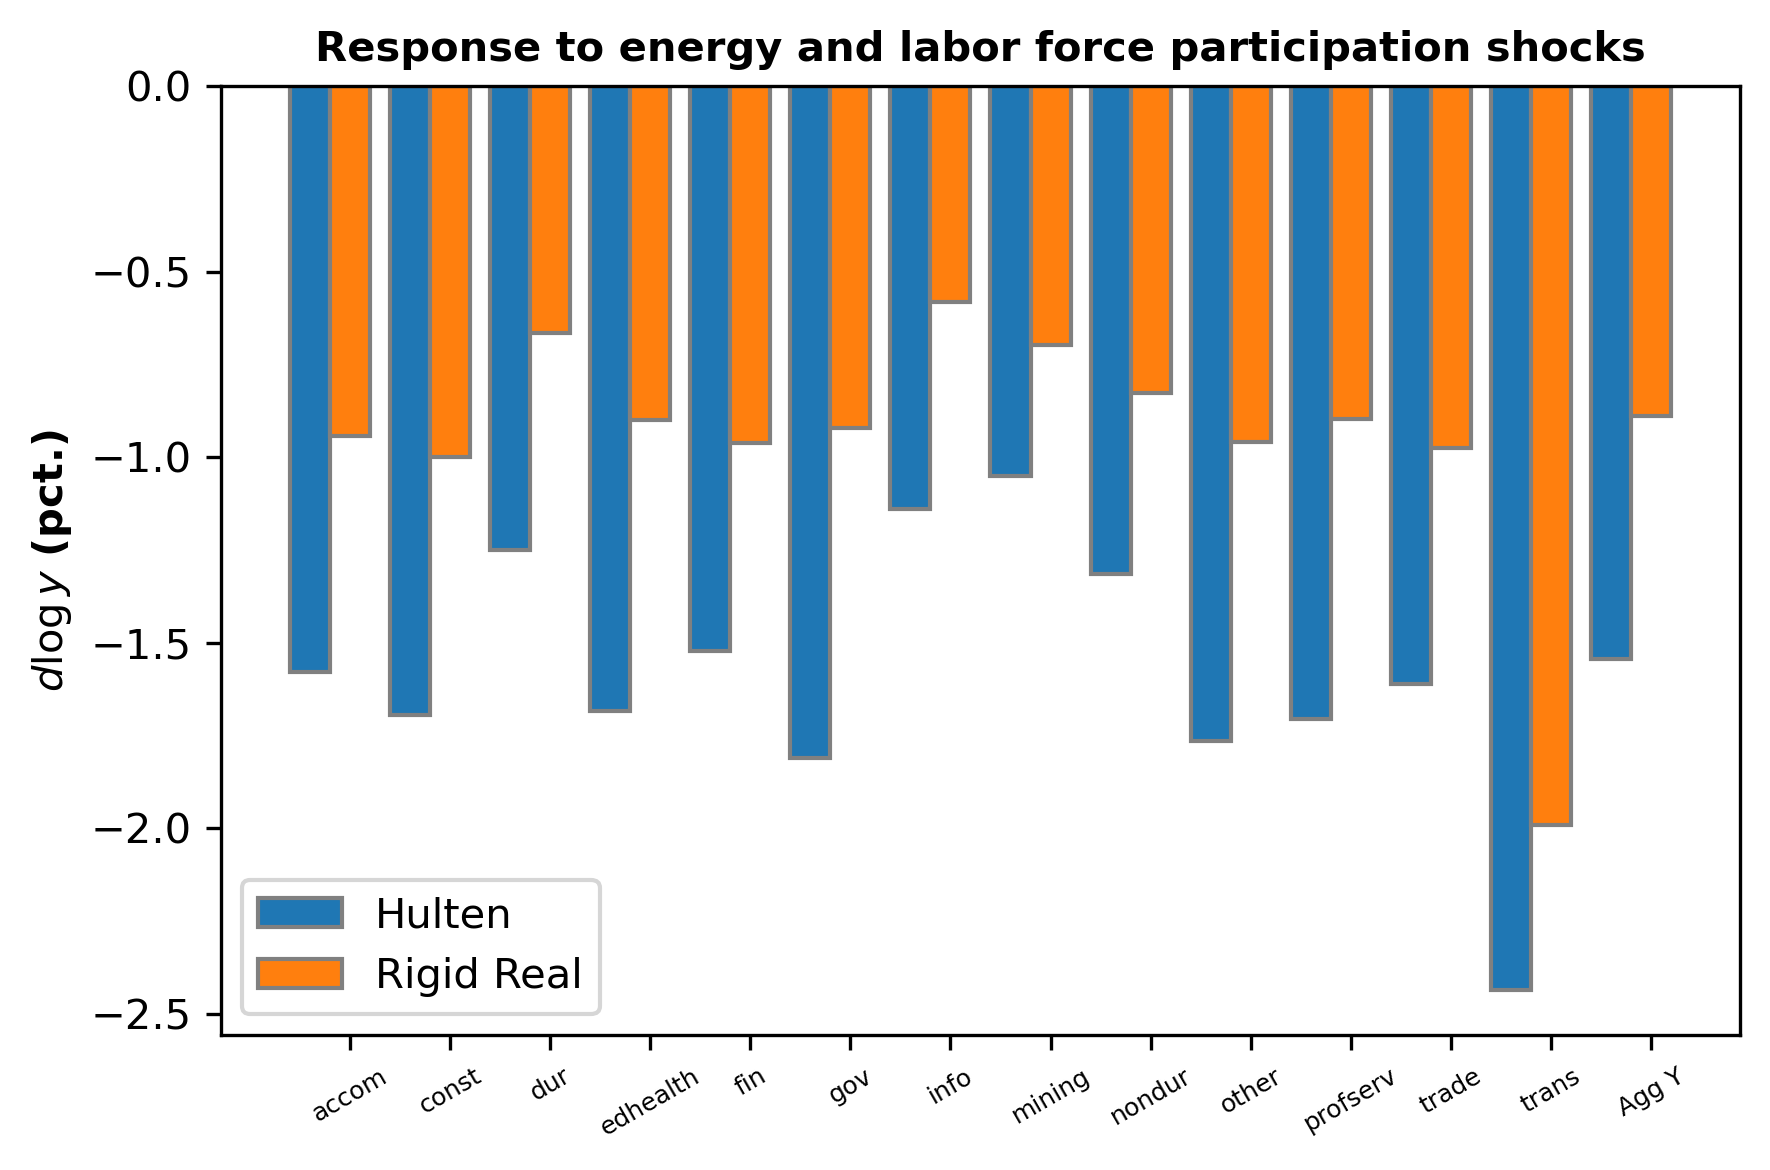

In [49]:
title = f'Response to energy and labor force participation shocks'
xlab = ''
ylab = '$d\log y$ (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_HKshockY_calib3.png'
labels = PriceAssumption
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

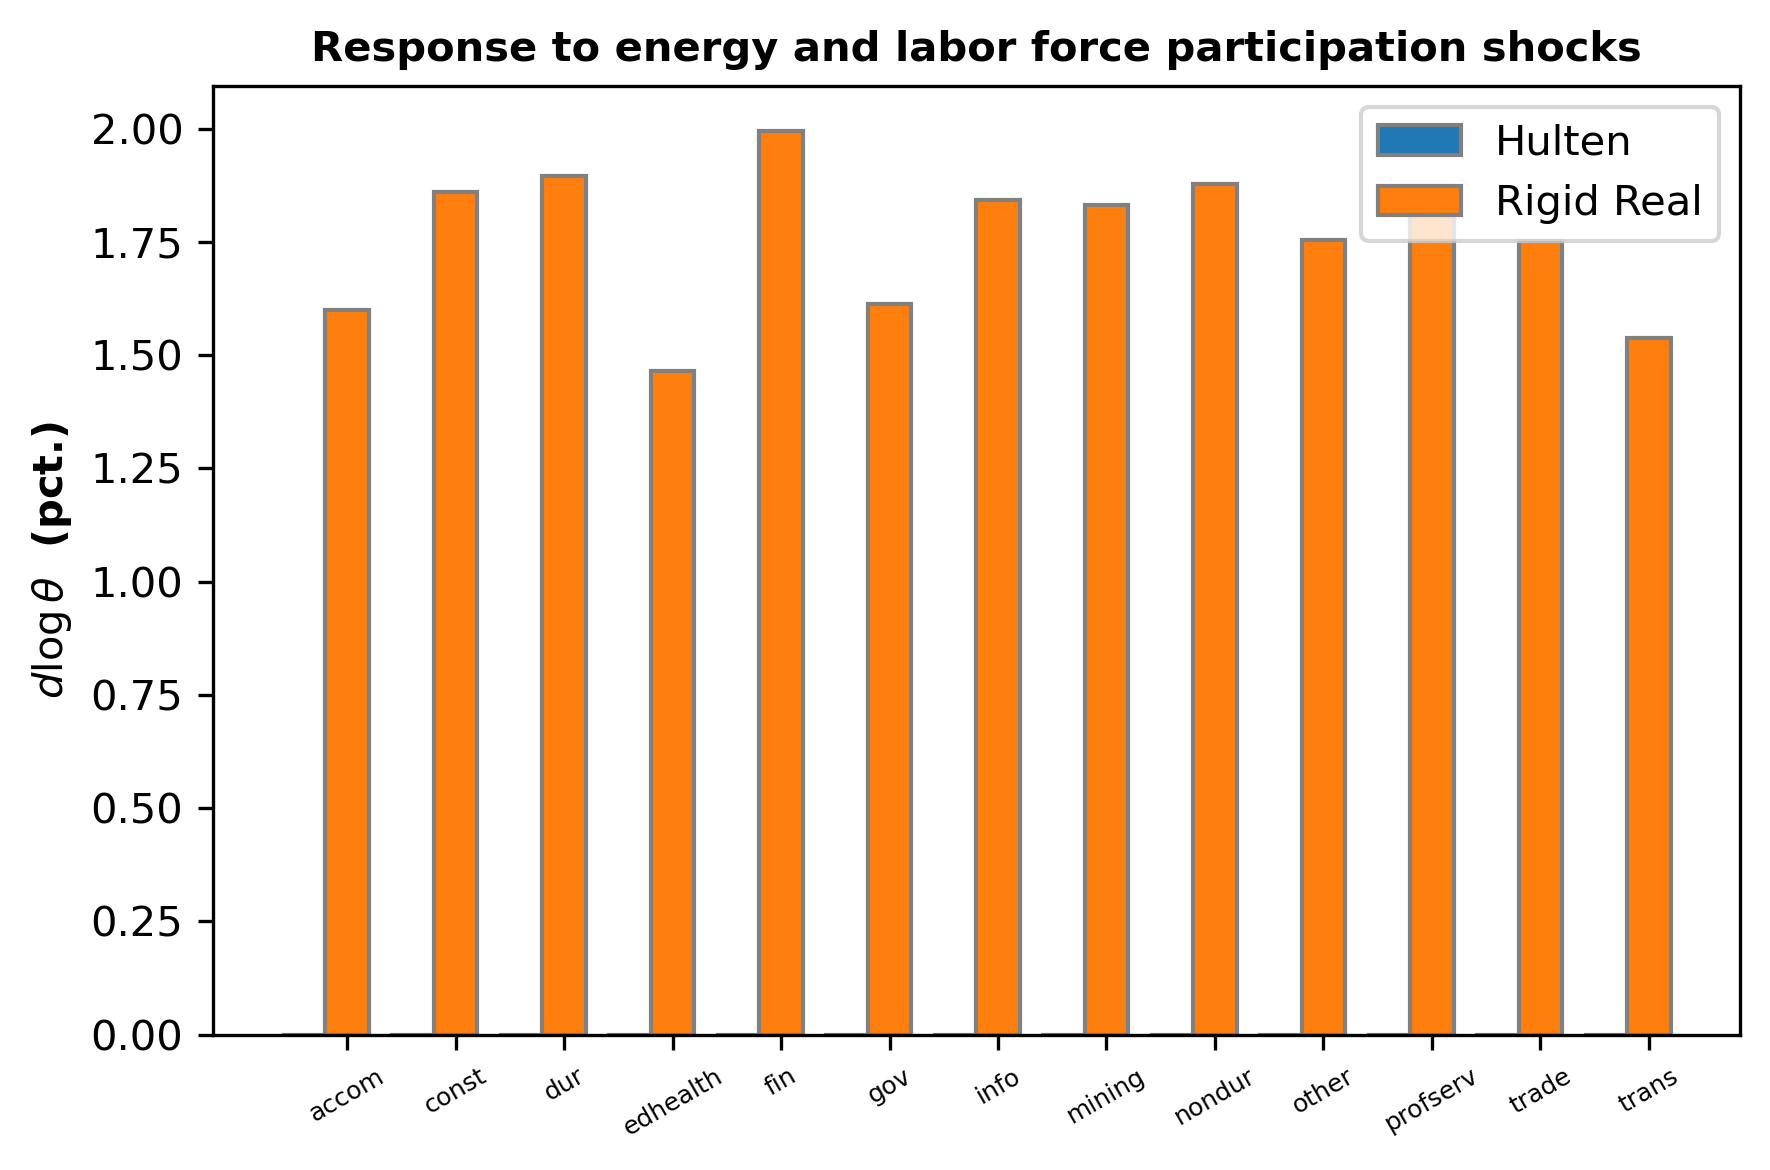

In [50]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_HKshockTsec_calib3.png'
labels = PriceAssumption
bar_plot(100*secT_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

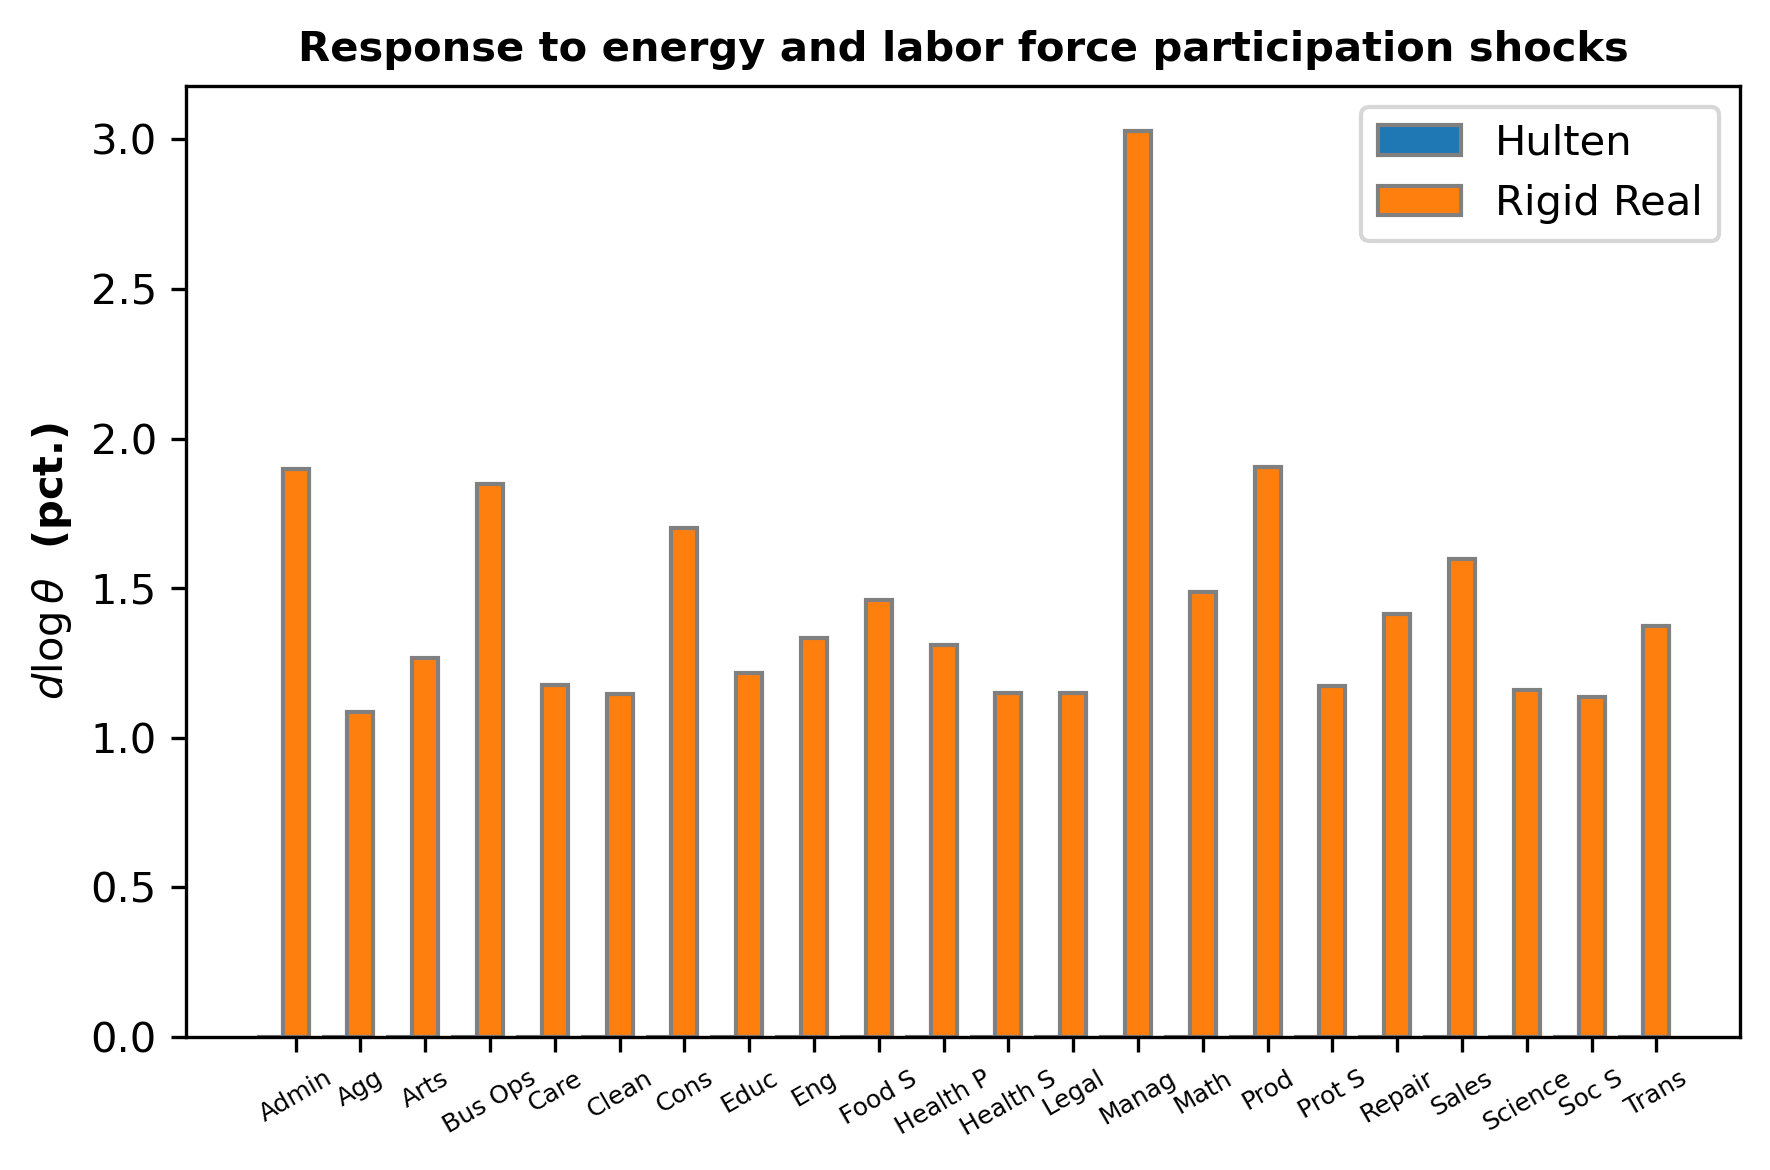

In [51]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_HKshockT_calib3.png'
labels = PriceAssumption
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

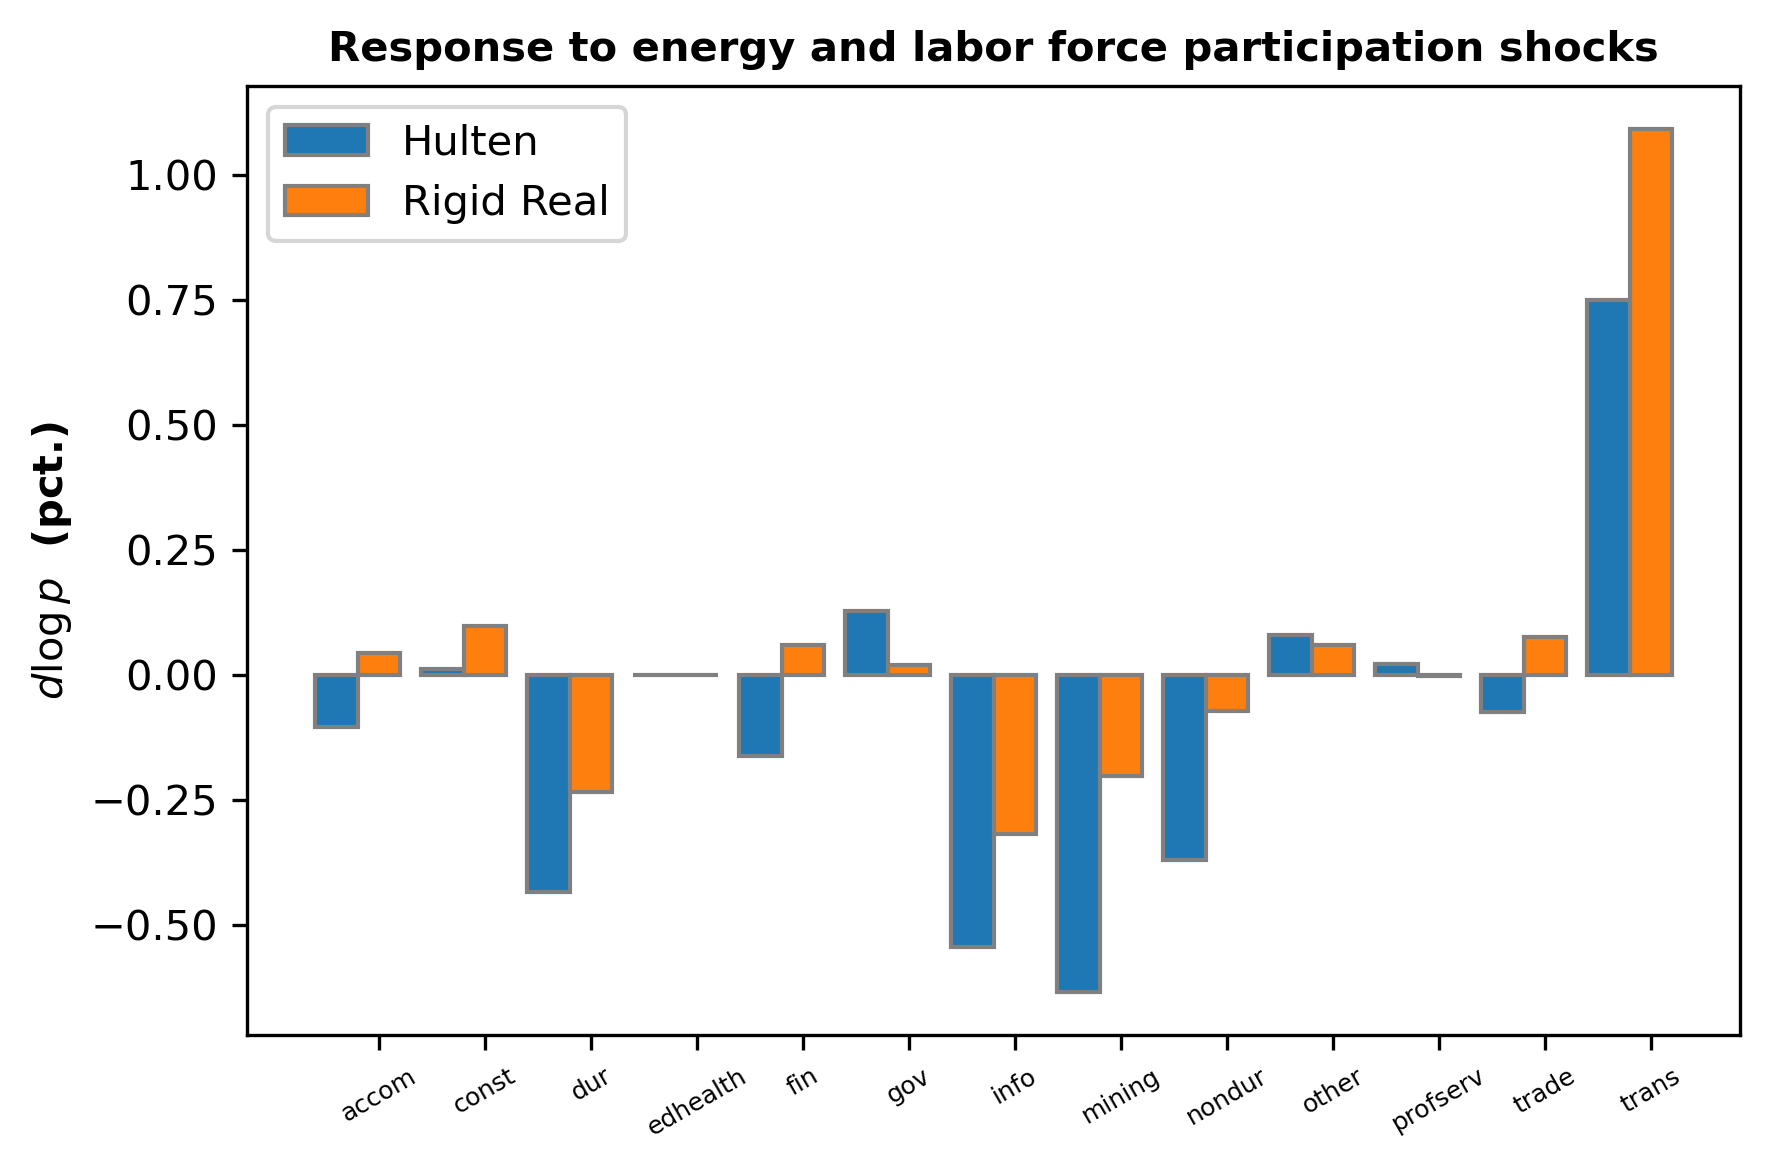

In [52]:
xlab = ''
ylab = '$d\log p$  (pct.)'
save_path = f'../output/figures/energy_A{A_spec}_HKshockP_calib3.png'
labels = PriceAssumption
bar_plot(100*p_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)